# 创新点：不需要考虑融合顺序
1.毫无疑问，RPS 的距离在基本层面上也属于排列距离的范畴。现在出现的一个问题是应该如何定义 RPS 中的距离度量。
2.然而，RPS 中两个 PMF 之间的差异测量尚未讨论。
3.

In [6]:
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from string import ascii_uppercase
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import itertools
import numpy as np
from collections.abc import Iterable
import copy
from collections import defaultdict

plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "savefig.format": "pdf",
    "lines.linewidth": 2,
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    'axes.labelweight': 'bold',
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "grid.alpha": 0.5,
    "font.family": "DejaVu Sans",  # 更稳定跨平台字体
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "text.usetex": False,
    "text.antialiased": True
})

# rps熵计算

In [7]:
def compute_rps_entropy(evidence):
    """
    严格遵循Example 4.1计算方法的RPS熵

    参数:
        evidence: 单个RPS证据体（字典格式，键为元组，值为质量）

    返回:
        entropy: 计算得到的熵值
    """
    total_entropy = 0.0

    # 预计算F(i)值（根据Example 4.1的算法）
    def compute_F(i):
        return sum(math.perm(i, k) for k in range(i + 1))

    # 计算每个证据项的贡献
    for items, mass in evidence.items():
        if mass <= 0:
            continue  # 跳过零质量项

        i = len(items)  # 当前组合长度
        F_i = compute_F(i)

        # 特别注意：Example中F(1)-1=2-1=1，但按定义F(1)=1! =1 → 需要确认
        # 根据Example 4.1的实际计算，F(1)=2, F(2)=5, F(3)=16
        # 这表明原定义可能有调整，这里采用示例中的值

        log_arg = mass / (F_i - 1)
        term = mass * math.log2(log_arg)  # term本身是负的
        total_entropy -= term  # 负负得正
        # print(f"组合 {items}: mass={mass}, log参数={log_arg:.4f}, term={term:.4f}, 贡献={-term:.4f}")
    # hypothesis_complexity = 1 - 1 / len(evidence)
    #     print(f"证据 {evidence}的总rps熵: total_entropy={total_entropy}")
    # 标准化到0-1范围（熵值越小质量越高）
    # print("total_entropy",total_entropy)
    max_possible_entropy = math.log(len(evidence) * 10)  # 经验值
    normalize_entropy = min(total_entropy / max_possible_entropy, 1.0)
    # print(f"证据 {evidence}的标准化熵: normalize_entropy={normalize_entropy}")
    return total_entropy

# owa相似度计算

# owa相似度优化

In [8]:
import numpy as np
from string import ascii_uppercase
from collections import defaultdict
from scipy.optimize import minimize

# ================== 缓存字母-数字映射 ==================
_letter_cache = {ch: idx + 1 for idx, ch in enumerate(ascii_uppercase)}

def to_numeric(x):
    """字母/数字映射，使用缓存加速"""
    if isinstance(x, str) and x.isalpha() and x in _letter_cache:
        return _letter_cache[x]
    return int(x)

# ================== 单例关系计算 ==================
_relation_cache = {}

def compute_singleton_relation(i, j):
    """单例-单例关系计算，带缓存"""
    key = tuple(sorted([i, j]))
    if key in _relation_cache:
        return _relation_cache[key]
    a, b = to_numeric(i), to_numeric(j)
    val = 1 - np.exp(-abs(a - b))
    _relation_cache[key] = val
    return val

# ================== 单例-集合关系 ==================
def compute_singleton_set(A, B, gamma):
    """单例到集合的关系，向量化"""
    B_numeric = np.array([to_numeric(b) for b in B])
    a_numeric = to_numeric(A)
    # 一次性计算所有 r(a,b)
    r_values = 1 - np.exp(-np.abs(a_numeric - B_numeric))
    return owa_aggregation(r_values, gamma, force_binary=False)

# ================== OWA聚合 ==================
def owa_aggregation(values, gamma=0.8, force_binary=False):
    """解析解版本 OWA 聚合"""
    values = np.array(values)
    n = len(values)
    if n == 1:
        return values[0]
    if force_binary:
        sorted_v = np.sort(values)[::-1]
        return gamma * sorted_v[0] + (1 - gamma) * sorted_v[1]

    # ===== 解析解求权重 =====
    # 原约束: sum(w)=1, sum((n-k-1)/(n-1)*w[k]) = gamma
    # 对于任意 n，可以解出 w1..wn 的解析解
    sorted_values = np.sort(values)[::-1]
    w = np.zeros(n)
    w[0] = gamma
    if n > 1:
        w[1:] = (1 - gamma) / (n - 1)
    return np.dot(sorted_values, w)

# ================== 构建关系矩阵 ==================
def build_relation_matrix(focal_elements, gamma=0.8):
    """构建关系矩阵，向量化 + 缓存"""
    n = len(focal_elements)
    R_o = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            A, B = focal_elements[i], focal_elements[j]

            # 单例-单例
            if len(A) == 1 and len(B) == 1:
                a, b = next(iter(A)), next(iter(B))
                R_o[i, j] = compute_singleton_relation(a, b)

            # 单例-集合
            elif len(A) == 1 and len(B) > 1:
                a = next(iter(A))
                R_o[i, j] = compute_singleton_set(a, B, gamma)

            # 集合-集合
            elif len(A) > 1 and len(B) > 1:
                # 向量化: 对集合A每个元素调用 compute_singleton_set
                r_values = np.array([compute_singleton_set(a, B, gamma) for a in A])
                R_o[i, j] = owa_aggregation(r_values, gamma, force_binary=False)

    # 对称填充
    R_o = np.triu(R_o) + np.triu(R_o, 1).T
    return R_o

# ================== 证据体距离 ==================
def d_OWA(m1, m2, gamma=0.8):
    """计算两个证据体之间的距离"""
    # 获取所有焦元（保持顺序）
    focal_elements = sorted(list(set(m1.keys()).union(set(m2.keys()))), key=lambda x: (len(x), x))

    # 构建关系矩阵
    R_o = build_relation_matrix(focal_elements, gamma)

    # 转向量
    m1_vec = np.array([m1.get(f, 0) for f in focal_elements])
    m2_vec = np.array([m2.get(f, 0) for f in focal_elements])

    # 计算距离
    diff = m1_vec - m2_vec
    M = 1 - R_o
    result = 0.5 * diff.T @ M @ diff
    # distance = np.sqrt(max(result, 0))  # 防止负数
    return result

# ================== 相似度矩阵 ==================
def owa_similarity_matrix(evidence, gamma=0.8):
    """计算证据体列表的相似度矩阵"""
    n = len(evidence)
    similarity_matrix = np.eye(n)

    for i in range(n):
        for j in range(i + 1, n):
            distance = d_OWA(evidence[i], evidence[j], gamma)
            similarity = 1 - distance
            # similarity_matrix[similarity_matrix < 0] = 0
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

    return similarity_matrix


# 置信度

In [9]:
def compute_credibility_from_similarity(S):
    """
    计算归一化的可信度权重 Crd
    - 输入: S (相似度矩阵)
    - 输出: Crd (可信度权重向量)
    """
    # 计算支持度 Sup(m_i)
    Sup = np.sum(S, axis=1) - np.diag(S)  # 去掉自身对自身的支持度
    # Sup = np.sum(S, axis=1)

    # 计算可信度 Crd 并归一化
    Crd = Sup / np.sum(Sup) if np.sum(Sup) != 0 else np.ones_like(Sup) / len(Sup)  # 避免除零

    return Crd

# 权重计算

In [10]:
def geometric_mean_correction_with_stats2(Crd, rps_weights_norm, eps=1e-12):
    """
    用几何均值 + Crd 的均值/方差构造逐元素修正因子（无条件判断版本）。
    返回归一化后的向量（和为1）。
    """
    Crd = np.asarray(Crd, dtype=float)
    rps = np.asarray(rps_weights_norm, dtype=float)

    # 全局统计量（自适应，无手动参数）
    mu = Crd.mean()
    sigma = Crd.std() + eps  # 防止除零

    # 标准化偏差 z（可正可负）
    # z = (Crd - mu) / sigma
    Delta_Cred_var = mu - Crd * (sigma / (mu + 1e-10))
    # print('Delta_Cred_var:', Delta_Cred_var)
    # 自适应系数 k：随分散度增加而增强调整力（无硬超参）
    k = 1 + (sigma / (mu + eps))

    M = k * Delta_Cred_var

    # 逐元素修正因子（z 越小 -> 因子越小）
    factor = np.exp(-Delta_Cred_var)
    # print('factor:', factor)
    # factor = np.power(rps,Delta_Cred_var)

    # 基础几何项（你之前用 abs 的版本效果不错）
    # 在乘法内加 eps 保证非负且避免 sqrt(0) 对数问题
    geometric_mean = np.sqrt(np.abs(Crd * factor)) * rps
    # 应用逐元素修正并归一化（确保输出是概率向量）
    # adjusted = geometric_mean * factor
    W = geometric_mean / (geometric_mean.sum() + eps)

    return W

# def compute_evidence_quality(evidence):
#     """综合质量评估（RPS熵+信息量+确定性）"""
#     prob = np.array(list(evidence.values()))
#     prob = prob / (np.sum(prob) + 1e-10)
#
#     # 1. RPS熵指标（取反，因为熵越低质量越高）
#     rps_entropy = compute_rps_entropy(evidence)
#     rps_score = 1- rps_entropy  # 已标准化
#
#     # 2. 信息量指标（香农熵）
#     # info_score = 1 - entropy(prob) / math.log(len(prob) + 1e-10)
#
#     # 3. 确定性指标
#     certainty = np.max(prob)
#
#     # 三重加权综合（可调参数）
#     # return 0.3 * rps_score + 0.7 * certainty
#     return certainty
#
# def compute_belief_from_similarity(S, evidence_list):
#     """
#     增强版置信度计算（三级融合）
#     参数：
#     - S: 相似度矩阵
#     - evidence_list: 证据体列表
#     - alpha: 质量主导系数 (0-1)
#     返回：
#     - belief_weights: 最终权重
#     """
#     n = len(evidence_list)
#     np.fill_diagonal(S, 0)  # 确保无自相似
#
#     # 第一阶段：基础可信度
#     Crd = compute_credibility_from_similarity(S)
#     # print("Crd；" , Crd)
#
#     # 第二阶段：质量评估（使用改进的compute_evidence_quality）
#     Quality = np.array([compute_evidence_quality(ev) for ev in evidence_list])
#     # print("Quality；" , Quality)
#     Q_norm = Quality / (np.sum(Quality) + 1e-10)
#     # print("Q_norm；" , Q_norm)
#
#     # 第三阶段：RPS熵加权一致性
#     rps_weights = np.array([1 - compute_rps_entropy(ev) for ev in evidence_list])
#     # print("rps_weights；" , rps_weights)
#     Consistency = np.sum(S * rps_weights.reshape(-1, 1), axis=1)
#     # print("Consistency；" , Consistency)
#     C_norm = Consistency / (np.sum(Consistency) + 1e-10)
#     # print("C_norm；" , C_norm)
#
#     # 动态融合（带可信度校准）
#     # combined = (alpha * Q_norm + (1 - alpha) * C_norm) * Crd
#     combined = (C_norm) ** Crd
#     belief_weights = combined / (np.sum(combined) + 1e-10)
#     # print("belief_weights；" , belief_weights)
#
#     return belief_weights
# def compute_rps_entropy(evidence):
#     """
#     严格遵循Example 4.1计算方法的RPS熵
#     参数:
#         evidence: 单个RPS证据体（字典格式，键为元组，值为质量）
#     返回:
#         entropy: 计算得到的熵值
#     """
#     total_entropy = 0.0
#
#     def compute_F(i):
#         return sum(math.perm(i, k) for k in range(i + 1))
#
#     for items, mass in evidence.items():
#         if mass <= 0:
#             continue
#         i = len(items)
#         F_i = compute_F(i)
#         log_arg = mass / (F_i - 1)
#         term = mass * math.log(log_arg) if log_arg > 0 else 0
#         total_entropy -= term
#
#     return total_entropy



def compute_certainty(evidence):
    """
    计算确定性指标（最大概率）
    参数:
        evidence: 单个RPS证据体
    返回:
        certainty: 确定性指标（0-1之间）
    """
    prob = np.array(list(evidence.values()))
    prob = prob / (np.sum(prob) + 1e-10)
    certainty = np.max(prob)
    return certainty

def compute_weights_with_both_metrics(S, evidence_list):
    """
    同时使用RPS熵和确定性指标的权重计算
    严格遵循公式6-4到6-8，并融入确定性指标
    """
    n = len(evidence_list)
    # np.fill_diagonal(S, 0)
    n = len(evidence_list)

    # 生成可靠性向量（线性衰减）
    if n == 1:
        reliability_vector = [1.0]
    else:
        reliability_vector = [(1 - 0.5 * i / (n - 1)) for i in range(n)]

    # 第一步：计算基础可信度 (公式6-4)
    Crd = compute_credibility_from_similarity(S)
    # print("Crd；" , Crd)
    # 第二步：计算RPS熵和归一化熵值 (公式6-5)
    # H_rps = np.array([compute_rps_entropy(ev) for ev in evidence_list])
    # H_rps_norm = H_rps / (np.sum(H_rps) + 1e-10)
    #     # 第三阶段：RPS熵加权一致性,权重越大越好
    rps_weights = np.array([compute_rps_entropy(ev) for ev in evidence_list])
    # print("rps_weights；" , rps_weights)
    rps_weights_norm = rps_weights / (np.sum(rps_weights) + 1e-10)
    # print("rps_weights_norm；" , rps_weights_norm)
    # 第三步：计算确定性指标
    Certainty = np.array([compute_certainty(ev) for ev in evidence_list])
    # print("Certainty；" , Certainty)
    Certainty_norm = Certainty / (np.sum(Certainty) + 1e-10)
    # print("Certainty_norm；" , Certainty_norm)

    all_cer = (1 - rps_weights_norm) + Certainty_norm
    # print("all_cer；" , all_cer)
    # 一致性：与其它源的相似度均值
    # Consistency = np.mean(S, axis=1)
# 计算一致性均值和标准差
#     consistency_means, consistency_std = compute_consistency_with_std(S)
    # print("Consistency；" , Consistency)
    # 第四步：计算可信度差值 (公式6-7)
    mean_cred = Crd.mean()
    Delta_Cred = mean_cred - Crd
    std_cred = Crd.std()   # 缓存标准差
    # Delta_Cred_var = (mean_cred - Crd) * (std_cred / mean_cred)
    Delta_Cred_var = mean_cred - Crd * (std_cred / (mean_cred + 1e-10))
    # print("mean_cred；" , mean_cred)
    # print("Delta_Cred_var；" , Delta_Cred_var)
    # 第五步：调整修正系数，同时考虑不确定性和确定性
    # 原修正系数：基于不确定性 (H_rps_norm)
    base_correction = np.power(rps_weights_norm, Delta_Cred_var)

    # print("Delta_Cred * all_cer",1+Delta_Cred * all_cer)
    # base_correction = np.exp(Delta_Cred * all_cer + 1)
    # print("base_correction",base_correction)
    # 调整策略：确定性越高，对不确定性的修正应该越谨慎
    # 高确定性证据：减少不确定性修正的影响
    # 低确定性证据：增强不确定性修正的影响
    # certainty_adjustment = 1.0 / (Certainty_norm + 0.5)  # 确定性越高，调整系数越小

    # 第六步：计算修正后的可信度 (公式6-6扩展)
    Cred_H = Crd * base_correction
    # print("Cred_H",Cred_H)
    # 第七步：最终权重归一化 (公式6-8)
    W = Cred_H / (np.sum(Cred_H) + 1e-10)
    W = geometric_mean_correction_with_stats2(Crd, rps_weights_norm)
    return W

# 软似然函数

In [11]:
import numpy as np

def similarity_based_soft_likelihood(omega, evidence_list, R_values, alpha=0.1, verbose=False):
    """
    Compute the soft likelihood (SLF) for a given hypothesis omega with detailed step prints.

    Parameters
    ----------
    omega : hashable
        The hypothesis to evaluate (e.g., 'W', 'X', etc.).
    evidence_list : list of dict
        List of RPS evidence, each as a dictionary mapping hypotheses to probabilities.
    R_values : list or np.ndarray
        Reliability degrees corresponding to each evidence source.
    alpha : float, optional
        Optimism coefficient for OWA weight calculation (default 0.1).
    verbose : bool, optional
        If True, prints detailed intermediate computation steps.

    Returns
    -------
    L : float
        Computed soft likelihood for hypothesis omega.
    """
    # Step 1: Extract support values
    prob_values = np.array([ev.get(omega, 0.0) for ev in evidence_list])
    weighted_support = prob_values * R_values

    if verbose:
        print(f"\nHypothesis: {omega}")
        print(f"Original support values: {prob_values}")

        print("\nWeighted support calculation:")
        for i, (p, r, ws) in enumerate(zip(prob_values, R_values, weighted_support)):
            print(f"  Source {i+1}: prob={p:.4f} * R={r:.4f} = {ws:.4f}")
        print(f"Weighted support (all): {weighted_support}")

    # Step 2: Sort by weighted support descending
    sorted_indices = np.argsort(weighted_support)[::-1]
    sorted_prob = prob_values[sorted_indices]
    sorted_R = np.array(R_values)[sorted_indices]

    if verbose:
        print(f"\nSorted indices (by weighted support): {sorted_indices}")
        print(f"Sorted probability values: {sorted_prob}")
        print(f"Sorted reliability values: {sorted_R}")

    # Step 3: Compute OWA weights with detailed printing
    w = []
    # print("\nStep 3: Compute OWA weights")
    power = (1 - alpha) / alpha
    for i in range(len(evidence_list)):
        if i == 0:
            weight = sorted_R[i] ** power
            # print(f"  i={i}, weight = sorted_R[{i}]^{power:.1f} = {sorted_R[i]:.4f}^{power:.1f} -> {weight:.4e}")
        else:
            cum_sum = np.sum(sorted_R[:i+1])
            cum_sum_prev = np.sum(sorted_R[:i])
            # print(f"  i={i}, cumulative sum details:")
            # for j in range(i+1):
                # print(f"     cum_sum += sorted_R[{j}] = {sorted_R[j]:.4f} -> {np.sum(sorted_R[:j+1]):.4f}")
            # for j in range(i):
                # print(f"     cum_sum_prev += sorted_R[{j}] = {sorted_R[j]:.4f} -> {np.sum(sorted_R[:j+1]):.4f}")
            weight = cum_sum ** power - cum_sum_prev ** power
            # print(f"       weight = {cum_sum:.4f}^{power:.1f} - {cum_sum_prev:.4f}^{power:.1f} = {weight:.4e}")
        w.append(weight)
    w = np.array(w)

    if verbose:
        print(f"\nComputed OWA weights: {w}")

    # Step 4: Compute soft likelihood with detailed intermediate steps
    L = 0.0
    # print("\nStep 4: Compute soft likelihood")
    for i in range(len(evidence_list)):
        prod = 1.0
        # print(f"\n  Step {i+1}:")
        for j in range(i+1):
            prod *= sorted_prob[j]
            # print(f"    Multiply prob[{j}]={sorted_prob[j]:.4f} -> partial product = {prod:.4f}")
        L += w[i] * prod
        # print(f"    Multiply by w[{i}]={w[i]:.4e} -> contribution to L = {w[i] * prod:.4e}")
        # print(f"    Cumulative L = {L:.4e}")

    if verbose:
        print(f"\nFinal soft likelihood L({omega}) = {L:.4f}\n")

    return L

# 软似然函数优化版

In [12]:
import numpy as np

def similarity_based_soft_likelihood_youhua(omega, evidence_list, R_values, alpha=0.1, verbose=False):
    """
    Optimized soft likelihood computation using vectorization.
    """
    # Step 1: Extract support values
    prob_values = np.array([ev.get(omega, 0.0) for ev in evidence_list])
    R_values = np.array(R_values)
    weighted_support = prob_values * R_values

    # Step 2: Sort by weighted support descending
    sorted_indices = np.argsort(weighted_support)[::-1]
    sorted_prob = prob_values[sorted_indices]
    sorted_R = R_values[sorted_indices]

    # Step 3: Vectorized OWA weight calculation
    power = (1 - alpha) / alpha
    cum_R = np.cumsum(sorted_R)
    cum_R_prev = np.insert(cum_R[:-1], 0, 0.0)  # 前一个累积和
    w = cum_R**power - cum_R_prev**power  # 向量化权重计算

    # Step 4: Vectorized soft likelihood computation
    cumprod_prob = np.cumprod(sorted_prob)  # 累乘概率
    L = np.dot(w, cumprod_prob)  # 最终加权累乘求和

    if verbose:
        print(f"Hypothesis: {omega}")
        print(f"Sorted probabilities: {sorted_prob}")
        print(f"Sorted reliability: {sorted_R}")
        print(f"OWA weights: {w}")
        print(f"Cumulative products: {cumprod_prob}")
        print(f"Soft likelihood: {L}")

    return L


# 证据修正

In [13]:
def rps_amplify(evidence_list, weights):
    # weights: numpy array
    mean_w = weights.mean()
    w_amp = weights / (mean_w + 1e-12)      # >1 for w>mean, <1 for w<mean
    S = {}
    for rps in evidence_list:
        vals = [e.get(subset, 0.0) for e in evidence_list]
    # 全局归一化（如果你需要概率分布）
    total = sum(S.values())
    if total > 0:
        for k in S:
            S[k] /= total
    return S

# 加权计算软融合

In [14]:
from collections import defaultdict
import math

def compute_M_w_soft_innovative(evidence_list, weights, pes, mode="relative"):
    M_w = defaultdict(float)

    for subset in pes:
        vals = [evi.get(subset, 0.0) for evi in evidence_list]

        if mode == "log":  # ---- 创新1：对数域累积
            score = sum(w * math.log1p(v) for w, v in zip(weights, vals))
            M_w[subset] = math.exp(score)

        elif mode == "relative":  # ---- 创新2：相对化加权
            numerator = sum(w * v for w, v in zip(weights, vals))
            denominator = sum(weights) * sum(vals) if sum(vals) > 0 else 1.0
            M_w[subset] = numerator / denominator

        elif mode == "root":  # ---- 创新3：平方根聚合
            score = sum(w * math.sqrt(v) for w, v in zip(weights, vals))
            M_w[subset] = score ** 2

    # ---- 最后统一归一化，体现“软”特性
    total = sum(M_w.values())
    if total > 0:
        for subset in M_w:
            M_w[subset] /= total

    return M_w


from collections import defaultdict
import math

def compute_M_w_hybrid(evidence_list, weights, pes):
    M_log = defaultdict(float)
    M_rel = defaultdict(float)
    M_hybrid = defaultdict(float)

    for subset in pes:
        vals = [evi.get(subset, 0.0) for evi in evidence_list]

        # ---- log 模式增强 (自适应 alpha = 平均权重)
        alpha = sum(weights) / len(weights)
        score_log = sum(w * math.log1p(alpha * v) for w, v in zip(weights, vals))
        M_log[subset] = math.exp(score_log)

        # ---- relative 模式
        numerator = sum(w * v for w, v in zip(weights, vals))
        denominator = sum(weights) * sum(vals) if sum(vals) > 0 else 1.0
        M_rel[subset] = numerator / denominator

        # ---- 混合模式 (几何均值融合)
        M_hybrid[subset] = math.sqrt(M_log[subset] * M_rel[subset])

    # ---- 归一化
    total = sum(M_hybrid.values())
    if total > 0:
        for subset in M_hybrid:
            M_hybrid[subset] /= total

    return dict(M_hybrid)

def absolute_weighted_sum_amplify(evidence_list, weights, pes):
    # weights: numpy array
    mean_w = weights.mean()
    w_amp = weights / (mean_w + 1e-12)      # >1 for w>mean, <1 for w<mean
    S = {}
    for subset in pes:
        vals = [e.get(subset, 0.0) for e in evidence_list]
        S[subset] = sum(w * v for w, v in zip(w_amp, vals))
    # 全局归一化（如果你需要概率分布）
    total = sum(S.values())
    if total > 0:
        for k in S:
            S[k] /= total
    return S


def absolute_weighted_sum_varscaled(evidence_list, weights, pes):
    mean_w = weights.mean()
    std_w = weights.std() + 1e-12
    # 放大系数跟随方差：差异大时弱化放大，差异小时保留放大
    scale = 1.0 / (1.0 + std_w)

    w_amp = (weights / mean_w) ** scale

    S = {}
    for subset in pes:
        vals = [e.get(subset, 0.0) for e in evidence_list]
        S[subset] = sum(w * v for w, v in zip(w_amp, vals))

    total = sum(S.values())
    if total > 0:
        for k in S:
            S[k] /= total
    return S

def absolute_weighted_sum_amplify_log(evidence_list, weights, pes):
    mean_w = weights.mean()
    # 对数放大：避免极端比例
    w_amp = np.log1p(weights) / np.log1p(mean_w + 1e-12)
    print("w_amp",w_amp)
    S = {}
    for subset in pes:
        vals = [e.get(subset, 0.0) for e in evidence_list]
        S[subset] = sum(w * v for w, v in zip(w_amp, vals))

    total = sum(S.values())
    if total > 0:
        for k in S:
            S[k] /= total
    return S
def weighted_consensus_rps(evidence_list, weights, pes):
    mean_w = weights.mean()
    # 对数放大：避免极端比例
    w_amp = np.log1p(weights) / np.log1p(mean_w + 1e-12)
    n = len(evidence_list)
    S = {subset: 0.0 for subset in pes}
    for i in range(n):
        for j in range(n):
            for subset in pes:
                avg_ev = np.mean([evidence_list[i].get(subset, 0.0), evidence_list[j].get(subset, 0.0)])
                S[subset] += w_amp[i] * w_amp[j] * avg_ev
    total = sum(S.values())
    for k in S:
        S[k] /= (total + 1e-12)
    return S
def absolute_weighted_sum_amplify_log_wuzhe(evidence_list, weights, pes):
    """
    改进版：对数放大 + 自适应平滑因子（无固定 lam）
    """
    weights = np.asarray(weights, dtype=float)
    mean_w = weights.mean()
    if mean_w <= 1e-12:
        mean_w = 1e-12

    # 对数放大（避免极端值）
    w_amp = np.log1p(weights) / np.log1p(mean_w)

    # 权重归一化（保持均值=1）
    w_amp /= w_amp.mean() + 1e-12

    # 自适应平滑因子（随权重分布调整，范围 0~0.3）
    lam = np.clip(weights.std() / (mean_w + 1e-12), 0.0, 0.3)

    # 融合平滑，避免过度倾斜
    w_amp = (1 - lam) * w_amp + lam

    S = {}
    for subset in pes:
        vals = [e.get(subset, 0.0) for e in evidence_list]
        # 加极小项避免 0/NaN
        S[subset] = sum(w * v for w, v in zip(w_amp, vals)) + 1e-12

    total = sum(S.values())
    if total > 0:
        for k in S:
            S[k] /= total
    else:
        n = len(S)
        if n > 0:
            for k in S:
                S[k] = 1.0 / n
    return S

# 融合函数入口

In [15]:
def fuse_evidence(evidence, R, hypotheses = {'A', 'B', 'C','D'}, alpha=0.1):
    """
    计算融合概率：
    - 使用软似然函数进行最终的概率估计
    - 输入: evidence (列表), 归一化后的证据列表；R (数组), 权重；alpha (浮点数), 乐观系数。
    - 输出: 融合后的概率分布。
    """
    # hypotheses = {
    # ('A',),
    # ('B',),
    # ('C',),
    # ('B', 'A'),
    # ('A', 'B'),
    # ('A', 'C'),
    # ('C', 'A', 'B'),
    # ('B', 'C', 'A'),
    # ('B', 'A', 'C'),
    # ('A', 'C', 'B'),
    # ('A', 'B', 'C')}
    # hypotheses = {'A', 'B', 'C','D','E'}
    fused = {}

    for omega in hypotheses:
        L = similarity_based_soft_likelihood(omega, evidence, R, alpha)
        fused[omega] = L

    # print("fused_result_before_nor:", convert_numpy_types(fused))
    # 归一化
    total_L = sum(fused.values()) + 1e-10
    fused = {k: v / total_L for k, v in fused.items()}
    # print("fused_result_after_nor:", convert_numpy_types(fused))
    return fused

# OPT计算

In [16]:
def calculate_OPT(pmf_data, hypotheses={'A', 'B', 'C','D'}):
    """
    直接基于假设集的OPT计算
    参数：
    - pmf_data: SLF融合后的概率分布字典 {tuple: prob}
    - hypotheses: 预设的假设集合
    返回：
    - 标准化后的OPT概率分布 {class: prob}
    """
    # 初始化概率分布
    P_OPT = {h: 0.0 for h in hypotheses}

    # 按命题长度排序处理（单元素优先）
    sorted_items = sorted(pmf_data.items(),
                          key=lambda x: (len(x[0]), x[0]))

    for items, mass in sorted_items:
        items_set = set(items)  # 转换为集合避免顺序影响
        if len(items_set) == 1:
            # 单元素直接分配
            theta = next(iter(items_set))  # 获取唯一元素
            P_OPT[theta] += mass
        else:
            # 多元素按OPT规则分配
            last_element = items[-1]  # 保持原顺序的最后一个元素
            for theta in items_set:
                if theta != last_element:
                    P_OPT[theta] += mass / (len(items_set) - 1)

    # 标准化处理
    total = sum(P_OPT.values())
    return {k: v / total for k, v in P_OPT.items()}

def batch_OPT(data_list, hypotheses = {'A', 'B', 'C','D'}):
    opt_list = []
    for d in data_list:
        opt_one  = calculate_OPT(d, hypotheses)
        print("opt_one:", convert_numpy_types(opt_one))
        opt_list.append(opt_one)
    return opt_list

# 连续左或右正交和

In [17]:
# -------------------------------
# 基础交集函数
# -------------------------------
def right_intersection(A, B):
    """
    右正交 (RI)，即 B 中去除不在 A 中的元素
    """
    return tuple(item for item in B if item in A)

def left_intersection(A, B):
    """
    左正交 (LI)，即 A 中去除不在 B 中的元素
    """
    return tuple(item for item in A if item in B)

# -------------------------------
# K 值计算
# -------------------------------
def calculate_KR(M1, M2):
    """
    计算右正交和的 K^R (K_R)
    输入: [(集合, 权重), ...]
    """
    K_R = 0
    for B, w1 in M1:
        for C, w2 in M2:
            if right_intersection(B, C) == ():
                K_R += w1 * w2
    return K_R

def calculate_KL(M1, M2):
    """
    计算左正交和的 K^L (K_L)
    """
    K_L = 0
    for B, w1 in M1:
        for C, w2 in M2:
            if left_intersection(B, C) == ():
                K_L += w1 * w2
    return K_L

# -------------------------------
# ROS 与 LOS
# -------------------------------
def ROS(M1, M2):
    """
    右正交和 (ROS)
    输入: [(集合, 权重), ...]
    输出: {集合: 权重, ...}，保留 0 值
    """
    K_R = calculate_KR(M1, M2)
    result = defaultdict(float)

    if K_R != 1:  # 防止除以 0
        # 遍历所有可能交集
        all_keys = set(A for A, _ in M1) | set(C for C, _ in M2)
        for A in all_keys:
            weight_sum = 0
            for B, w1 in M1:
                for C, w2 in M2:
                    if right_intersection(B, C) == A:
                        weight_sum += w1 * w2
            result[A] = (1 / (1 - K_R)) * weight_sum  # 即使 weight_sum=0 也保留

    return dict(result)

def LOS(M1, M2):
    """
    左正交和 (LOS)
    """
    K_L = calculate_KL(M1, M2)
    result = defaultdict(float)

    if K_L != 1:  # 防止除以 0
        all_keys = set(A for A, _ in M1) | set(C for C, _ in M2)
        for A in all_keys:
            weight_sum = 0
            for B, w1 in M1:
                for C, w2 in M2:
                    if left_intersection(B, C) == A:
                        weight_sum += w1 * w2
            result[A] = (1 / (1 - K_L)) * weight_sum

    return dict(result)

# -------------------------------
# 连续正交和
# -------------------------------
def dict_to_pmf(rps_dict):
    """
    将字典格式 {('A',): 0.99, ...} 转换为 [(集合, 权重), ...]
    """
    return [(k, v) for k, v in rps_dict.items()]

def continuous_right_orthogonal_sum(PMFs):
    """
    连续执行右正交和操作
    输入: [ {('A',):0.9,...}, {...}, ... ]
    输出: {集合: 权重, ...}
    """
    result = dict_to_pmf(PMFs[0])
    for i in range(1, len(PMFs)):
        result = ROS(result, dict_to_pmf(PMFs[i])).items()
    return dict(result)

def continuous_left_orthogonal_sum(PMFs):
    """
    连续执行左正交和操作
    """
    result = dict_to_pmf(PMFs[0])
    for i in range(1, len(PMFs)):
        result = LOS(result, dict_to_pmf(PMFs[i])).items()
    return dict(result)

# PIC算法

In [18]:
import math
from typing import Dict, List, Tuple, Union
import numpy as np
def calculate_pic(probabilities: Union[Dict[str, float], List[float], np.ndarray],
                 elements: List[str] = None) -> float:
    """
    计算概率信息量 (Probabilistic Information Content - PIC)

    根据公式: PIC(P) = 1 + (1/log₂N) * Σ P(θ)log₂(P(θ))

    Args:
        probabilities: 概率分布，可以是:
            - 字典: {元素: 概率}
            - 列表: 概率值列表（需要提供elements参数）
            - numpy数组: 概率值数组（需要提供elements参数）
        elements: 可选，元素名称列表，当probabilities不是字典时需要提供

    Returns:
        float: PIC值，范围[0, 1]

    Raises:
        ValueError: 概率和为1或包含无效值
    """
    # 处理不同类型的输入
    if isinstance(probabilities, dict):
        probs = list(probabilities.values())
        N = len(probabilities)
    else:
        if elements is not None:
            N = len(elements)
        else:
            N = len(probabilities)
        probs = probabilities

    # 转换为numpy数组便于计算
    probs = np.array(probs)

    # 验证输入
    if not np.all(probs >= 0):
        raise ValueError("所有概率值必须非负")

    if not math.isclose(np.sum(probs), 1.0, rel_tol=1e-10):
        raise ValueError(f"概率和必须为1，当前和为{np.sum(probs):.6f}")

    if N <= 0:
        raise ValueError("元素数量必须大于0")

    # 计算PIC
    entropy_term = 0.0
    for p in probs:
        if p > 0:  # 避免log(0)
            entropy_term += p * math.log2(p)

    # PIC = 1 - 归一化香农熵
    pic_value = 1 + (1 / math.log2(N)) * entropy_term

    return pic_value

# meowa算法

In [19]:
def solve_meowa_weights_exact(n, orness):
    """
    严格遵循图片中公式2-27和2-28的MEOWA权重求解
    """
    if n == 1:
        return np.array([1.0])

    if orness == 0.5:
        return np.ones(n) / n

    # 公式2-27：构造方程
    def equation(h):
        result = 0
        for i in range(1, n + 1):
            term = ((n - i) / (n - 1) - orness) * (h ** (n - i))
            result += term
        return result

    # 精确求解h*
    if orness > 0.5:
        h_low, h_high = 1.0, 100.0
    else:
        h_low, h_high = 0.001, 0.999

    tolerance = 1e-12  # 更高的精度
    max_iter = 1000

    for _ in range(max_iter):
        h_mid = (h_low + h_high) / 2
        f_mid = equation(h_mid)

        if abs(f_mid) < tolerance:
            h_star = h_mid
            break

        if equation(h_low) * f_mid < 0:
            h_high = h_mid
        else:
            h_low = h_mid
    else:
        h_star = (h_low + h_high) / 2

    # 公式2-28：计算权重向量
    denominator = 0
    weights = np.zeros(n)

    for i in range(1, n + 1):
        weights[i-1] = h_star ** (n - i)
        denominator += weights[i-1]

    return weights / denominator
def meowa_probability_conversion_exact(rps_data, orness=0.5):
    """
    严格遵循公式2-29的MEOWA概率转换
    """
    all_elements = set()
    for permutation in rps_data.keys():
        all_elements.update(permutation)
    all_elements = sorted(all_elements)

    probability_dist = {element: 0.0 for element in all_elements}

    for permutation, mass in rps_data.items():
        if mass == 0:
            continue

        n = len(permutation)
        weights = solve_meowa_weights_exact(n, orness)

        for idx, element in enumerate(permutation):
            rank = idx + 1
            weight_value = weights[rank - 1]
            probability_dist[element] += weight_value * mass

    return probability_dist

# 主函数入口

In [20]:
def main_function(evidence, hypotheses_all, hypotheses = {'A', 'B', 'C','D'}):
    # 处理证据体格式
    # normalized_evidence = normalize_evidence(evidence)
    # OPT_evidence = batch_OPT(evidence, hypotheses)

    # 计算相似度矩阵
    S = owa_similarity_matrix(evidence)

    # 计算权重 R
    # print(S)
    # 计算综合置信度权重
    R_values = compute_weights_with_both_metrics(S, evidence)
    print("Optimal R:", R_values)
# Crd； [0.23478793 0.09370717 0.23994348 0.21806852 0.21349289]
#     R_values = [0.2406,0.0899,0.2409,0.2251,0.2034]
    # 计算融合概率
    alpha = 0.1 # 乐观系数
    # fused_probabilities = fuse_evidence(evidence, R_values, hypotheses_all, alpha)
    fused_probabilities = weighted_consensus_rps(evidence,R_values,hypotheses_all)
    # print("fused_probabilities:", convert_numpy_types(fused_probabilities))


    # rps_list_r = [copy.deepcopy(fused_probabilities) for _ in range(len(evidence))]

    # 使用连续左交和
    # ros_result = continuous_right_orthogonal_sum(rps_list_r)
    # los_result = continuous_right_orthogonal_sum(rps_list_r)
    ros_result = dict(fused_probabilities)
    N = len(evidence)
    for _ in range(N - 1):
        ros_result = zhou_combination(ros_result, fused_probabilities)
    print("Optimal los:", convert_numpy_types(ros_result))

    # fused_end = meowa_probability_conversion_exact(M_f,orness=0.7)
    fused_end = calculate_OPT(ros_result, hypotheses)
    # print("Fused end:", convert_numpy_types(fused_end))
    pic_uniform = calculate_pic(fused_end)
    print(f"均匀分布: PIC = {pic_uniform:.6f}")
    return fused_end

In [21]:
def convert_numpy_types(obj):
    """
    递归转换数据结构中的 np.int64 和 np.float64 为 Python 原生类型
    支持处理: 列表/元组/集合/字典/嵌套结构
    """
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, (str, bytes, bytearray)):
        return obj
    elif isinstance(obj, dict):
        return {convert_numpy_types(k): convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, Iterable) and not isinstance(obj, (str, bytes)):
        return type(obj)(convert_numpy_types(x) for x in obj)
    else:
        return obj

# rps生成函数

## 生成所有按顺序选择的排列组合

In [22]:
# 生成所有按顺序选择的排列组合
def get_ordered_permutations(num_classes):
    result = []
    # 逐步增加元素数量
    for i in range(1, num_classes + 1):
        # 生成i个元素的全排列
        result.extend(itertools.permutations(range(i), i))
    return result

## 计算 weighted PMF

In [23]:
# 计算 weighted PMF
def calculate_weighted_pmf(weight_matrix, sorted_nmv):
    num_combinations, num_attributes = weight_matrix.shape
    num_classes = sorted_nmv.shape[0]  # 获取类的数量（classes）

    # 获取排列组合
    # all_combinations = get_ordered_permutations(num_classes)

    # 初始化 weighted_pmf 矩阵
    weighted_pmf = np.zeros_like(weight_matrix)

    # 记录当前组合数对应的起始位置
    current_row = 0

    # 遍历组合大小 i（从 1 到 num_classes）
    for i in range(1, num_classes + 1):
        num_permutations = len(list(itertools.permutations(range(i), i)))  # 当前大小的排列组合数量

        # 遍历每个属性 j
        for j in range(num_attributes):
            # 对于当前大小 i 的排列组合，使用 sorted_nmv[i-1, j]
            # 组合有几个类，就乘于多少行
            weighted_pmf[current_row:current_row + num_permutations, j] = (
                    weight_matrix[current_row:current_row + num_permutations, j] * sorted_nmv[i - 1, j]
            )

        # 更新起始行
        current_row += num_permutations

    return weighted_pmf

## rps生成

In [24]:
# 获取按顺序选择的排列组合
def gen_rps_fun(test_size=0.2):
    # 1. 加载Iris数据集并划分为训练集和测试集
    iris = load_iris()
    X = iris.data  # 四个属性
    y = iris.target  # 三个类 (0, 1, 2)
    num_classes = len(np.unique(iris.target))
    num_attributes = iris.data.shape[1]
    # 将数据集划分为训练集和测试集，乱序
    # print("\n当前 (test_size):\n", test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42)
    # 2. 计算每个类中每个属性的 mean value and standard deviation (无偏估计)
    mean_std_by_class = []
    for class_label in np.unique(y_train):
        X_class = X_train[y_train == class_label]
        mean_std = [(np.mean(X_class[:, i]), np.std(X_class[:, i], ddof=1)) for i in range(X_class.shape[1])]
        mean_std_by_class.append(mean_std)

    mean_std_by_class = np.array(mean_std_by_class)
    # print("每个类中每个属性的均值和标准差:\n", mean_std_by_class)
    # print("Shape of mean_std_by_class:\n", mean_std_by_class.shape)
    # 3. 为每个类和每个属性建立高斯分布函数，并对测试集中随机选取的一个样本进行预测

    # 保存下(3,4)个Gaussian distribution函数
    # 创建一个(3,4)的函数数组，用来存储每个类中每个属性的高斯分布函数
    # 对于每个类中的每个属性，计算该样本在该属性下的高斯分布的概率密度值。
    gaussian_functions = np.empty((3, 4), dtype=object)

    # 初始化并保存高斯分布函数
    for class_label in range(num_classes):
        for i in range(num_attributes):  # 四个属性
            mean, std = mean_std_by_class[class_label, i]
            # 保存高斯分布函数
            gaussian_functions[class_label, i] = norm(loc=mean, scale=std)

    # 随机选择一个测试集中的样本
    rand_idx = np.random.randint(0, len(X_test))
    test_sample = X_test[rand_idx]
    # true_label = y_test[rand_idx]   # ✅ 这就是生成数据对应的真实标签
    # 计算该测试样本在每个类中每个属性的高斯分布结果
    gaussian_results = []
    for class_label in range(num_classes):
        class_results = []
        for i in range(num_attributes):  # 四个属性
            # 调用保存的高斯分布函数，计算概率密度值
            # pdf是SciPy的norm对象的方法，用于计算给定值在该正态分布下的概率密度值。
            pdf_value = gaussian_functions[class_label, i].pdf(test_sample[i])
            class_results.append(pdf_value)
        gaussian_results.append(class_results)

    gaussian_results = np.array(gaussian_results)
    # print("\n测试集中选取的样本:", test_sample)
    # print("\n每个类中每个属性的高斯分布函数值:\n", gaussian_results)
    column_sums = np.sum(gaussian_results, axis=0)
    normalized_results = gaussian_results / column_sums
    # print("\n每个属性针对所有类的归一化后的MV (归一化后的高斯分布值):\n", normalized_results)
    # 对归一化后的MV（normalized membership vector）进行降序排序，并保留原始顺序的索引
    sorted_indices = np.argsort(-normalized_results, axis=0)  # 降序排序，使用负号实现降序
    sorted_nmv = np.take_along_axis(normalized_results, sorted_indices, axis=0)  # 按照索引排序后的值
    sorted_gaussian_functions = np.take_along_axis(gaussian_functions, sorted_indices, axis=0)  # 按照索引排序后的GDM

    # 打印结果
    # print("\n归一化后的MV降序排序的结果:\n", sorted_nmv)
    # print("\n每个元素排序前的原始类索引:\n", sorted_indices)
    x_mean_ord = np.empty((3, 4))
    std_ord = np.empty((3, 4))

    # mean_std_by_class 的 shape 是 (3, 4, 2)，索引 [class, attribute, 0] 获取均值，索引 [class, attribute, 1] 获取标准差
    for attr_idx in range(num_attributes):  # 对每个属性进行操作
        for class_idx in range(num_classes):  # 对每个类进行操作
            sorted_class_idx = sorted_indices[class_idx, attr_idx]  # 获取排序后的类索引
            x_mean_ord[class_idx, attr_idx] = mean_std_by_class[sorted_class_idx, attr_idx, 0]  # 获取排序后的均值
            std_ord[class_idx, attr_idx] = mean_std_by_class[sorted_class_idx, attr_idx, 1]  # 获取排序后的标准差

    # print("\n排序后的 x_mean_ord:\n", x_mean_ord)
    # print("\n排序后的 std_ord:\n", std_ord)
    supporting_degree = np.exp(-np.abs(test_sample - x_mean_ord))

    # print("\nSupporting degree (支持度):\n", supporting_degree)
    all_combinations = get_ordered_permutations(num_classes)
    # print(all_combinations)
    # 初始化权重矩阵 weight_matrix
    num_combinations = len(all_combinations)  # 所有按顺序排列组合的数量 (应该是9)
    weight_matrix = np.zeros((num_combinations, num_attributes))  # (9, 4)

    # 对每个属性计算权重,也就是每个属性下的权重
    for attr_idx in range(num_attributes):
        # 取第一列，第一列对应属性1
        s = supporting_degree[:, attr_idx]  # 取出该属性对应的支持度 (3,)

        # 遍历每个组合，计算 w(i1...iu...iq)
        for comb_idx, combination in enumerate(all_combinations):
            q = len(combination)  # 该组合的长度
            weight = 1.0  # 初始化权重

            # 根据公式 (19) 计算权重
            for u in range(q):
                i_u = combination[u]  # 当前排列项 i_u
                numerator = s[i_u]  # 分子支持度
                denominator_sum = np.sum(s[list(combination[u:])])  # 分母，从 u 到 q 的支持度和
                weight *= numerator / denominator_sum  # 按公式累乘

            # 将计算好的权重保存到 weight_matrix
            weight_matrix[comb_idx, attr_idx] = weight

    # 输出权重矩阵
    # print("\n权重矩阵 (Weight matrix):\n", weight_matrix)
    weighted_pmf = calculate_weighted_pmf(weight_matrix, sorted_nmv)
    # print("weighted_pmf",weighted_pmf)
    RPS_w = []
    for j in range(num_attributes):
        RPS_w_j = set()

        thetas = sorted_indices[:, j]
        weighted_pmf_j = weighted_pmf[:, j]

        for idx, combination in enumerate(all_combinations):
            A = thetas[list(combination)]
            M_A = weighted_pmf_j[idx]
            A = tuple((A))
            RPS_w_j.add((A, M_A))

        RPS_w.append(RPS_w_j)
    return RPS_w

In [25]:
# 需要修改gen_rps_fun为接受训练数据和单个测试样本的版本
def gen_rps_fun_for_sample(X_train, y_train, test_sample):
    """为单个测试样本生成RPS"""
    num_classes = len(np.unique(y_train))
    num_attributes = X_train.shape[1]

    # 计算每个类中每个属性的 mean value and standard deviation
    mean_std_by_class = []
    for class_label in np.unique(y_train):
        X_class = X_train[y_train == class_label]
        mean_std = [(np.mean(X_class[:, i]), np.std(X_class[:, i], ddof=1)) for i in range(X_class.shape[1])]
        mean_std_by_class.append(mean_std)

    mean_std_by_class = np.array(mean_std_by_class)

    # 为每个类和每个属性建立高斯分布函数
    gaussian_functions = np.empty((num_classes, num_attributes), dtype=object)
    for class_label in range(num_classes):
        for i in range(num_attributes):
            mean, std = mean_std_by_class[class_label, i]
            gaussian_functions[class_label, i] = norm(loc=mean, scale=std)

    # 计算该测试样本在每个类中每个属性的高斯分布结果
    gaussian_results = []
    for class_label in range(num_classes):
        class_results = []
        for i in range(num_attributes):
            pdf_value = gaussian_functions[class_label, i].pdf(test_sample[i])
            class_results.append(pdf_value)
        gaussian_results.append(class_results)

    gaussian_results = np.array(gaussian_results)
    column_sums = np.sum(gaussian_results, axis=0)
    normalized_results = gaussian_results / column_sums

    # 对归一化后的MV进行降序排序
    sorted_indices = np.argsort(-normalized_results, axis=0)
    sorted_nmv = np.take_along_axis(normalized_results, sorted_indices, axis=0)

    x_mean_ord = np.empty((num_classes, num_attributes))
    for attr_idx in range(num_attributes):
        for class_idx in range(num_classes):
            sorted_class_idx = sorted_indices[class_idx, attr_idx]
            x_mean_ord[class_idx, attr_idx] = mean_std_by_class[sorted_class_idx, attr_idx, 0]

    supporting_degree = np.exp(-np.abs(test_sample - x_mean_ord))
    all_combinations = get_ordered_permutations(num_classes)

    # 初始化权重矩阵
    num_combinations = len(all_combinations)
    weight_matrix = np.zeros((num_combinations, num_attributes))

    # 对每个属性计算权重
    for attr_idx in range(num_attributes):
        s = supporting_degree[:, attr_idx]
        for comb_idx, combination in enumerate(all_combinations):
            q = len(combination)
            weight = 1.0
            for u in range(q):
                i_u = combination[u]
                numerator = s[i_u]
                denominator_sum = np.sum(s[list(combination[u:])])
                weight *= numerator / denominator_sum
            weight_matrix[comb_idx, attr_idx] = weight

    weighted_pmf = calculate_weighted_pmf(weight_matrix, sorted_nmv)
    RPS_w = []

    for j in range(num_attributes):
        RPS_w_j = set()
        thetas = sorted_indices[:, j]
        weighted_pmf_j = weighted_pmf[:, j]

        for idx, combination in enumerate(all_combinations):
            A = thetas[list(combination)]
            M_A = weighted_pmf_j[idx]
            RPS_w_j.add((tuple(A), M_A))

        RPS_w.append(RPS_w_j)

    return RPS_w

In [26]:
# 定义映射关系
index_to_label = {0: 'S', 1: 'E', 2: 'V'}

# 转换函数
def convert_to_labeled_rps(gen_rps):
    labeled_evidence = []
    for rps in gen_rps:
        converted = {}
        for items, mass in rps:
            # 转换数字索引为字母标签
            labeled_items = tuple(index_to_label[i] for i in items)
            converted[labeled_items] = mass
        labeled_evidence.append(converted)
    return labeled_evidence

In [27]:
def extract_hypotheses(evidence_rps):
    """
    从RPS证据结构中抽取所有唯一的假设组合

    参数:
        evidence_rps: 包含多个RPS证据字典的列表

    返回:
        包含所有唯一假设的集合(set)，每个假设是一个元组
    """
    hypotheses = set()
    for evidence in evidence_rps:
        hypotheses.update(evidence.keys())
    return hypotheses

# 周的组合

In [28]:
from typing import Dict, Tuple, List
from collections import defaultdict
import math
from itertools import permutations, combinations
def zhou_combination(M1_dict: Dict[Tuple, float], M2_dict: Dict[Tuple, float]) -> Dict[Tuple, float]:
    """
    通用的Zhou组合规则实现
    输入格式: {('A',): 0.7, ('B',): 0.15, ('C',): 0.15}
    输出格式: {排列元组: 质量值}
    """
    # 步骤1: 提取所有元素并生成幂集和幂排列集
    all_elements = _extract_all_elements(M1_dict, M2_dict)
    ps = _generate_power_set(all_elements)
    pes = _generate_power_permutation_set(all_elements)

    # 步骤2: 补全输入字典
    full_M1 = _complete_input_dict(M1_dict, all_elements)
    full_M2 = _complete_input_dict(M2_dict, all_elements)

    # 步骤3: 还原BPA分布
    bpa1 = _pmf_to_bpa(full_M1, ps)
    bpa2 = _pmf_to_bpa(full_M2, ps)

    # 步骤4: Dempster组合
    combined_bpa = _dempster_combination(bpa1, bpa2, ps)

    # 步骤5: 计算序一致度 π(B_i^j)
    pi_values = _calculate_pi_values(full_M1, full_M2, ps, all_elements)

    # 步骤6: 计算权重 w(B_i^j)
    w_values = _calculate_weight_values(pi_values, ps, all_elements)

    # 步骤7: 分配信念
    result_pmf = _distribute_belief(combined_bpa, w_values, ps, all_elements)

    # 步骤8: 归一化并返回结果
    return _normalize_result(result_pmf)

# ==================== 辅助函数 ====================

def _extract_all_elements(*dicts):
    """从所有字典中提取唯一元素"""
    all_elements = set()
    for d in dicts:
        for perm in d.keys():
            all_elements.update(perm)
    return sorted(all_elements)

def _generate_power_set(elements):
    """生成幂集 PS(Θ)"""
    ps = []
    for i in range(len(elements) + 1):
        for comb in combinations(elements, i):
            ps.append(tuple(sorted(comb)))
    return ps

def _generate_power_permutation_set(elements):
    """生成幂排列集 PES(Θ)"""
    pes = []
    for i in range(len(elements) + 1):
        for perm in permutations(elements, i):
            pes.append(perm)
    return pes

def _get_all_permutations(subset):
    """获取给定子集的所有排列"""
    if not subset:
        return [()]
    return list(permutations(subset))

def _kendall_tau_distance(perm1, perm2):
    """计算两个排列的肯德尔秩相关系数"""
    common_elements = set(perm1) & set(perm2)
    if len(common_elements) < 2:
        return 1.0 if len(common_elements) == 1 else 0.0

    concordant = 0
    discordant = 0
    common_list = list(common_elements)

    for i in range(len(common_list)):
        for j in range(i + 1, len(common_list)):
            a, b = common_list[i], common_list[j]

            # 获取在两个排列中的相对顺序
            try:
                a1, b1 = perm1.index(a), perm1.index(b)
                a2, b2 = perm2.index(a), perm2.index(b)

                if (a1 < b1 and a2 < b2) or (a1 > b1 and a2 > b2):
                    concordant += 1
                else:
                    discordant += 1
            except ValueError:
                continue

    total_pairs = len(common_list) * (len(common_list) - 1) // 2
    return (concordant - discordant) / total_pairs if total_pairs > 0 else 0.0

def _complete_input_dict(input_dict, elements):
    """补全输入字典，确保包含所有单元素排列"""
    completed = defaultdict(float)

    # 添加输入的所有项
    for perm, mass in input_dict.items():
        completed[perm] += mass

    # 确保所有单元素排列都存在（即使质量为0）
    for elem in elements:
        single_perm = (elem,)
        if single_perm not in completed:
            completed[single_perm] = 0.0

    return dict(completed)

def _pmf_to_bpa(pmf_dict, ps):
    """将PMF转换为BPA"""
    bpa = defaultdict(float)
    for subset in ps:
        bpa_value = 0.0
        for perm in _get_all_permutations(subset):
            bpa_value += pmf_dict.get(perm, 0.0)
        if bpa_value > 0:
            bpa[subset] = bpa_value
    return dict(bpa)

def _dempster_combination(bpa1, bpa2, ps):
    """Dempster组合规则"""
    combined = defaultdict(float)
    conflict = 0.0

    for s1, m1 in bpa1.items():
        for s2, m2 in bpa2.items():
            intersection = tuple(sorted(set(s1) & set(s2)))
            product = m1 * m2

            if intersection:
                combined[intersection] += product
            else:
                conflict += product

    # 归一化
    if conflict < 1.0:
        normalization = 1.0 - conflict
        for key in combined:
            combined[key] /= normalization

    return dict(combined)

def _calculate_pi_values(M1, M2, ps, elements):
    """计算序一致度 π(B_i^j)"""
    pi_values = {}

    for subset in ps:
        for perm in _get_all_permutations(subset):
            # 基本项: ℳ_1(B_i^j) + ℳ_2(B_i^j)
            pi = M1.get(perm, 0.0) + M2.get(perm, 0.0)

            # 超集项求和
            for superset in ps:
                if set(subset).issubset(set(superset)) and len(superset) > len(subset):
                    for super_perm in _get_all_permutations(superset):
                        tau = _kendall_tau_distance(super_perm, perm)
                        pi += tau * (M1.get(super_perm, 0.0) + M2.get(super_perm, 0.0))

            pi_values[perm] = pi

    return pi_values

def _calculate_weight_values(pi_values, ps, elements):
    """计算权重 w(B_i^j)"""
    w_values = {}

    for subset in ps:
        perms = _get_all_permutations(subset)
        total_pi = sum(pi_values.get(perm, 0.0) for perm in perms)

        for perm in perms:
            if total_pi > 0:
                w_values[perm] = pi_values.get(perm, 0.0) / total_pi
            else:
                # 平均分配权重
                w_values[perm] = 1.0 / len(perms) if perms else 0.0

    return w_values

def _distribute_belief(combined_bpa, w_values, ps, elements):
    """分配信念 ℳ(B_i^j) = m_ℳ(B_i) × w(B_i^j)"""
    result_pmf = {}

    for subset in ps:
        bpa_value = combined_bpa.get(subset, 0.0)
        for perm in _get_all_permutations(subset):
            result_pmf[perm] = bpa_value * w_values.get(perm, 0.0)

    return result_pmf

def _normalize_result(result_pmf):
    """归一化结果"""
    total = sum(result_pmf.values())
    if total > 0:
        result_pmf = {k: v / total for k, v in result_pmf.items()}

    # 过滤掉接近零的值
    return {k: v for k, v in result_pmf.items() if v > 1e-10}

# 方法调用

In [29]:
     # 你的证据体
# 论文应用例子
evidenceList = []
evidence5 = [
    {  # 传感器1
        ('A',): 0.31,
        ('B',): 0.0,
        ('C',): 0.29,
        ('A', 'C',): 0.0,
        ('C', 'A',): 0.0,
        ('A', 'B', 'C'): 0.0167,
        ('A', 'C', 'B'): 0.0167,
        ('B', 'A', 'C'): 0.0167,
        ('B', 'C', 'A'): 0.0167,
        ('C', 'A', 'B'): 0.3167,
        ('C', 'B', 'A'): 0.0167
    },
    {  # 传感器2
        ('A',): 0.0,
        ('B',): 0.8,
        ('C',): 0.2,
        ('A', 'C',): 0.0,
        ('C', 'A',): 0.0,
        ('A', 'B', 'C'): 0.0,
        ('A', 'C', 'B'): 0.0,
        ('B', 'A', 'C'): 0.0,
        ('B', 'C', 'A'): 0.0,
        ('C', 'A', 'B'): 0.0,
        ('C', 'B', 'A'): 0.0
    },
    {  # 传感器3
        ('A',): 0.27,
        ('B',): 0.07,
        ('C',): 0.21,
        ('A', 'C',): 0.0,
        ('C', 'A',): 0.0,
        ('A', 'B', 'C'): 0.025,
        ('A', 'C', 'B'): 0.025,
        ('B', 'A', 'C'): 0.025,
        ('B', 'C', 'A'): 0.025,
        ('C', 'A', 'B'): 0.325,
        ('C', 'B', 'A'): 0.025
    },
    {  # 传感器4
        ('A',): 0.25,
        ('B',): 0.05,
        ('C',): 0.3,
        ('A', 'C',): 0.09,
        ('C', 'A',): 0.31,
        ('A', 'B', 'C'): 0.0,
        ('A', 'C', 'B'): 0.0,
        ('B', 'A', 'C'): 0.0,
        ('B', 'C', 'A'): 0.0,
        ('C', 'A', 'B'): 0.0,
        ('C', 'B', 'A'): 0.0
    },
    {  # 专家
        ('A',): 0.25,
        ('B',): 0.0,
        ('C',): 0.2,
        ('A', 'C'): 0.36,
        ('C', 'A'): 0.0,
        ('A', 'B', 'C'): 0.0233,
        ('A', 'C', 'B'): 0.0733,
        ('B', 'A', 'C'): 0.0233,
        ('B', 'C', 'A'): 0.0233,
        ('C', 'A', 'B'): 0.0233,
        ('C', 'B', 'A'): 0.0233
    }
]
# evidenceList.append(evidence5)

evidence_rps = [
    {  # 第一组RPS证据
        ('A',): 0.2,
        ('B',): 0.08,
        ('C',): 0.0,
        ('B', 'A'): 0.05,
        ('A', 'B'): 0.12,
        ('A', 'C'): 0.03,
        ('C', 'A'): 0.0,
        ('A', 'B', 'C'): 0.12,
        ('B', 'A', 'C'): 0.1,
        ('B', 'C', 'A'): 0.05,
        ('A', 'C', 'B'): 0.25,
        ('C', 'A', 'B'): 0.0,
    },
    {  # 第二组RPS证据
        ('A',): 0.07,
        ('B',): 0.13,
        ('C',): 0.02,
        ('B', 'A'): 0.2,
        ('A', 'B'): 0.07,
        ('A', 'C'): 0.1,
        ('C', 'A'): 0.0,
        ('C', 'A', 'B'): 0.08,
        ('B', 'C', 'A'): 0.0,
        ('B', 'A', 'C'): 0.2,
        ('A', 'C', 'B'): 0.0,
        ('A', 'B', 'C'): 0.13
    },
    {  # 第三组RPS证据
        ('A',): 0.14,
        ('B',): 0.09,
        ('C',): 0.0,
        ('B', 'A'): 0.08,
        ('A', 'B'): 0.12,
        ('A', 'C'): 0.00,
        ('C', 'A'): 0.0,
        ('C', 'A', 'B'): 0.05,
        ('B', 'C', 'A'): 0.0,
        ('B', 'A', 'C'): 0.1,
        ('A', 'C', 'B'): 0.3,
        ('A', 'B', 'C'): 0.12
    }
]
# evidenceList.append(evidence_rps)

# 论文例子4.1
example4_1 = [
    {  # RPS₁
        ('A',): 0.4,        # W -> A
        ('B', 'C'): 0.2,    # X,Y -> B,C
        ('C', 'B'): 0.3,    # Y,X -> C,B
        ('D',): 0.1         # Z -> D
    },
    {  # RPS₂
        ('A',): 0.5,        # W -> A
        ('B', 'C'): 0.3,    # X,Y -> B,C
        ('C', 'B'): 0.1,    # Y,X -> C,B
        ('D',): 0.1         # Z -> D
    },
    {  # RPS₃
        ('A',): 0.2,        # W -> A
        ('B', 'C'): 0.4,    # X,Y -> B,C
        ('C', 'B'): 0.2,    # Y,X -> C,B
        ('D',): 0.2         # Z -> D
    },
    {  # RPS₄
        ('A',): 0.1,        # W -> A
        ('B', 'C'): 0.2,    # X,Y -> B,C
        ('C', 'B'): 0.2,    # Y,X -> C,B
        ('D',): 0.5         # Z -> D
    }
]
# evidenceList.append(example4_1)

example5_2 = [
    {  # RPS₁
        ('A',): 0.0,  # 零质量可保留或移除
        ('B', 'C'): 0.05,
        ('C', 'B'): 0.05,  # 顺序敏感保留
        ('D',): 0.9
    },
    {  # RPS₂
        ('A',): 0.9,
        ('B', 'C'): 0.05,
        ('C', 'B'): 0.05,
        ('D',): 0.0
    },
    {  # RPS₃
        ('A',): 0.8,
        ('B', 'C'): 0.05,
        ('C', 'B'): 0.05,
        ('D',): 0.1
    }
]
# evidenceList.append(example5_2)
# 论文例子4.2
example4_2 = [
    {  # RPS₁
        ('A',): 0.9,
        ('B', 'C'): 0.015,
        ('C', 'B'): 0.0,  # 显式保留零值
        ('D',): 0.085
    },
    {  # RPS₂
        ('A',): 0.0,
        ('B', 'C'): 0.015,
        ('C', 'B'): 0.9,  # 注意与RPS₁的顺序相反
        ('D',): 0.085
    },
    {  # RPS₃
        ('A',): 0.45,
        ('B', 'C'): 0.015,
        ('C', 'B'): 0.45,  # 顺序敏感值
        ('D',): 0.085
    }
]
# evidenceList.append(example4_2)
example5_4 = [
    {  # RPS₁
        ('A', 'B', 'C'): 0.9,
        ('A', 'C', 'B'): 0.0,  # 显式保留零值
        ('B', 'A', 'C'): 0.05,
        ('D',): 0.05
    },
    {  # RPS₂
        ('A', 'B', 'C'): 0.0,
        ('A', 'C', 'B'): 0.9,  # 注意顺序差异
        ('B', 'A', 'C'): 0.05,
        ('D',): 0.05
    },
    {  # RPS₃
        ('A', 'B', 'C'): 0.5,
        ('A', 'C', 'B'): 0.4,  # 顺序敏感值
        ('B', 'A', 'C'): 0.05,
        ('D',): 0.05
    }
]
# evidenceList.append(example5_4)
# 论文例子4.3
example4_3 = [
    {  # RPS₁
        ('A',): 0.3,        # X -> B
        ('B', 'C'): 0.3,    # X,Y -> B,C
        ('C', 'B'): 0.3,    # Y,X -> C,B
        ('D',): 0.1         # Z -> D
    },
    {  # RPS₂
        ('A',): 0.33,       # X -> B
        ('B', 'C'): 0.33,   # X,Y -> B,C
        ('C', 'B'): 0.33,   # Y,X -> C,B
        ('D',): 0.01        # Z -> D
    },
    {  # RPS₃
        ('A',): 0.3,        # X -> B
        ('B', 'C'): 0.5,    # X,Y -> B,C
        ('C', 'B'): 0.1,    # Y,X -> C,B
        ('D',): 0.1         # Z -> D
    }
]
evidenceList.append(example4_3)

# evidenceList.append(labeled_evidence1)
# test_size_list = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
# test_size_list = [0.8]
# for test_size in test_size_list:
#     gen_rps = gen_rps_fun(test_size)
#     # print(convert_numpy_types(gen_rps))
#     # print("true_label",true_label)
#     convert_numpy_types(gen_rps)
#     labeled_evidence = convert_to_labeled_rps(gen_rps)
#     print("labeled_evidence",labeled_evidence)
#     evidenceList.append(labeled_evidence)
# hypotheses = {'W', 'X', 'Y', 'Z'}
# hypotheses = {'S', 'E', 'V'}
hypotheses = {'A', 'B', 'C','D'}
label_to_index = {'A': 0, 'B': 1, 'C': 2}
index_fuse = []
for evidence in evidenceList:
    hypotheses_all = extract_hypotheses(evidence)
    result = main_function(evidence, hypotheses_all, hypotheses)
    pred = max(result, key=result.get)
    index_fuse.append(label_to_index[pred])
    print(result)
print(index_fuse)

Optimal R: [0.34596154 0.33154589 0.32249258]
Optimal los: {('A',): 0.1109682519699556, ('D',): 0.001285732270399069, ('B', 'C'): 0.5366428577636541, ('C', 'B'): 0.3511031579959913}
均匀分布: PIC = 0.311811
{'B': np.float64(0.5366428577636541), 'A': np.float64(0.1109682519699556), 'D': np.float64(0.001285732270399069), 'C': np.float64(0.3511031579959913)}
[1]


# 结果制图

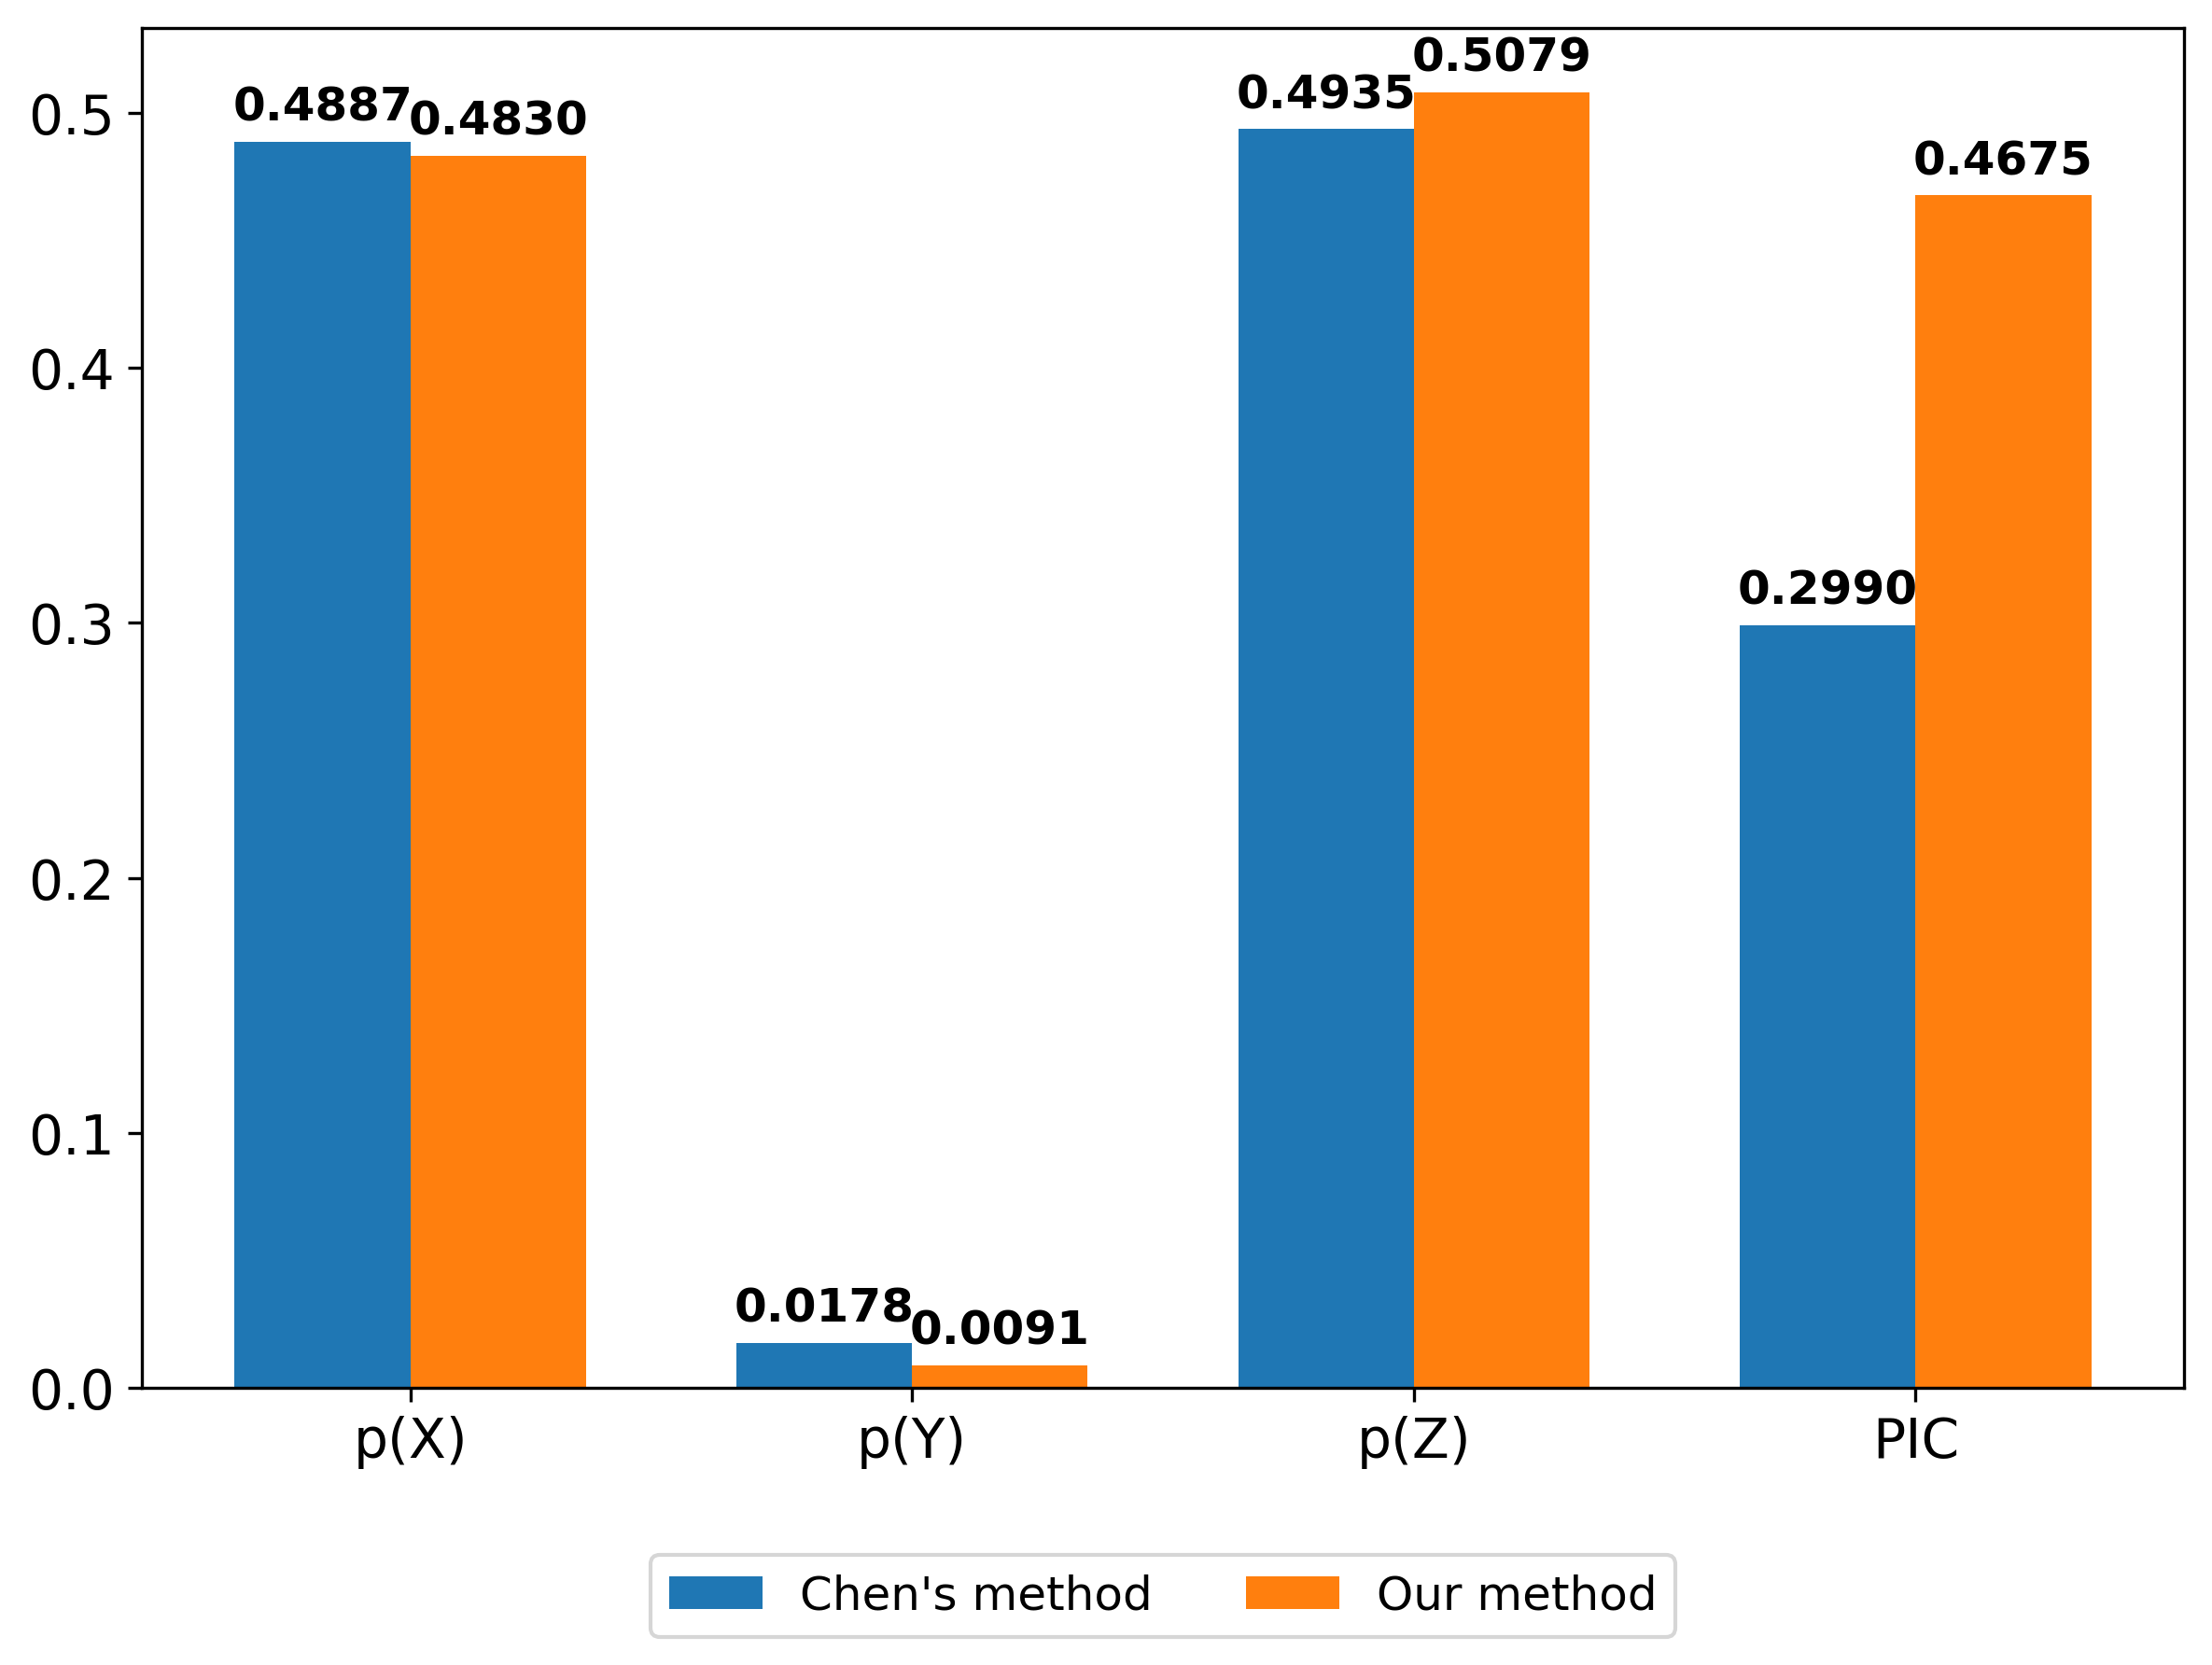

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
labels = ['p(X)', 'p(Y)', 'p(Z)', 'PIC']
W3_case1 = [0.4887, 0.0178, 0.4935, 0.2990]
W3_case2 = [0.4830, 0.0091, 0.5079, 0.4675]
x = np.arange(len(labels))  # x轴位置
width = 0.35  # 柱宽

# 创建画布
fig, ax = plt.subplots(figsize=(8, 6))

# 柱状图
rects1 = ax.bar(x - width/2, W3_case1, width, label='Chen\'s method')
rects2 = ax.bar(x + width/2, W3_case2, width, label='Our method')

# 其他设置
# ax.set_ylabel('Values')
# ax.set_xlabel('Metrics')
# ax.set_title('Comparison of W3 Cases')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# 图例放在右边
ax.legend(
    loc='lower center',        # 图例基准点在下方中间
    bbox_to_anchor=(0.5, -0.2),  # 调整位置 (0.5表示居中，-0.25表示在图表下方留出空间)
    ncol=2,                    # 两列显示
    fontsize=12
)

# 在柱顶显示数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=12,fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig("example4_4.pdf", bbox_inches='tight', transparent=True)
plt.show()

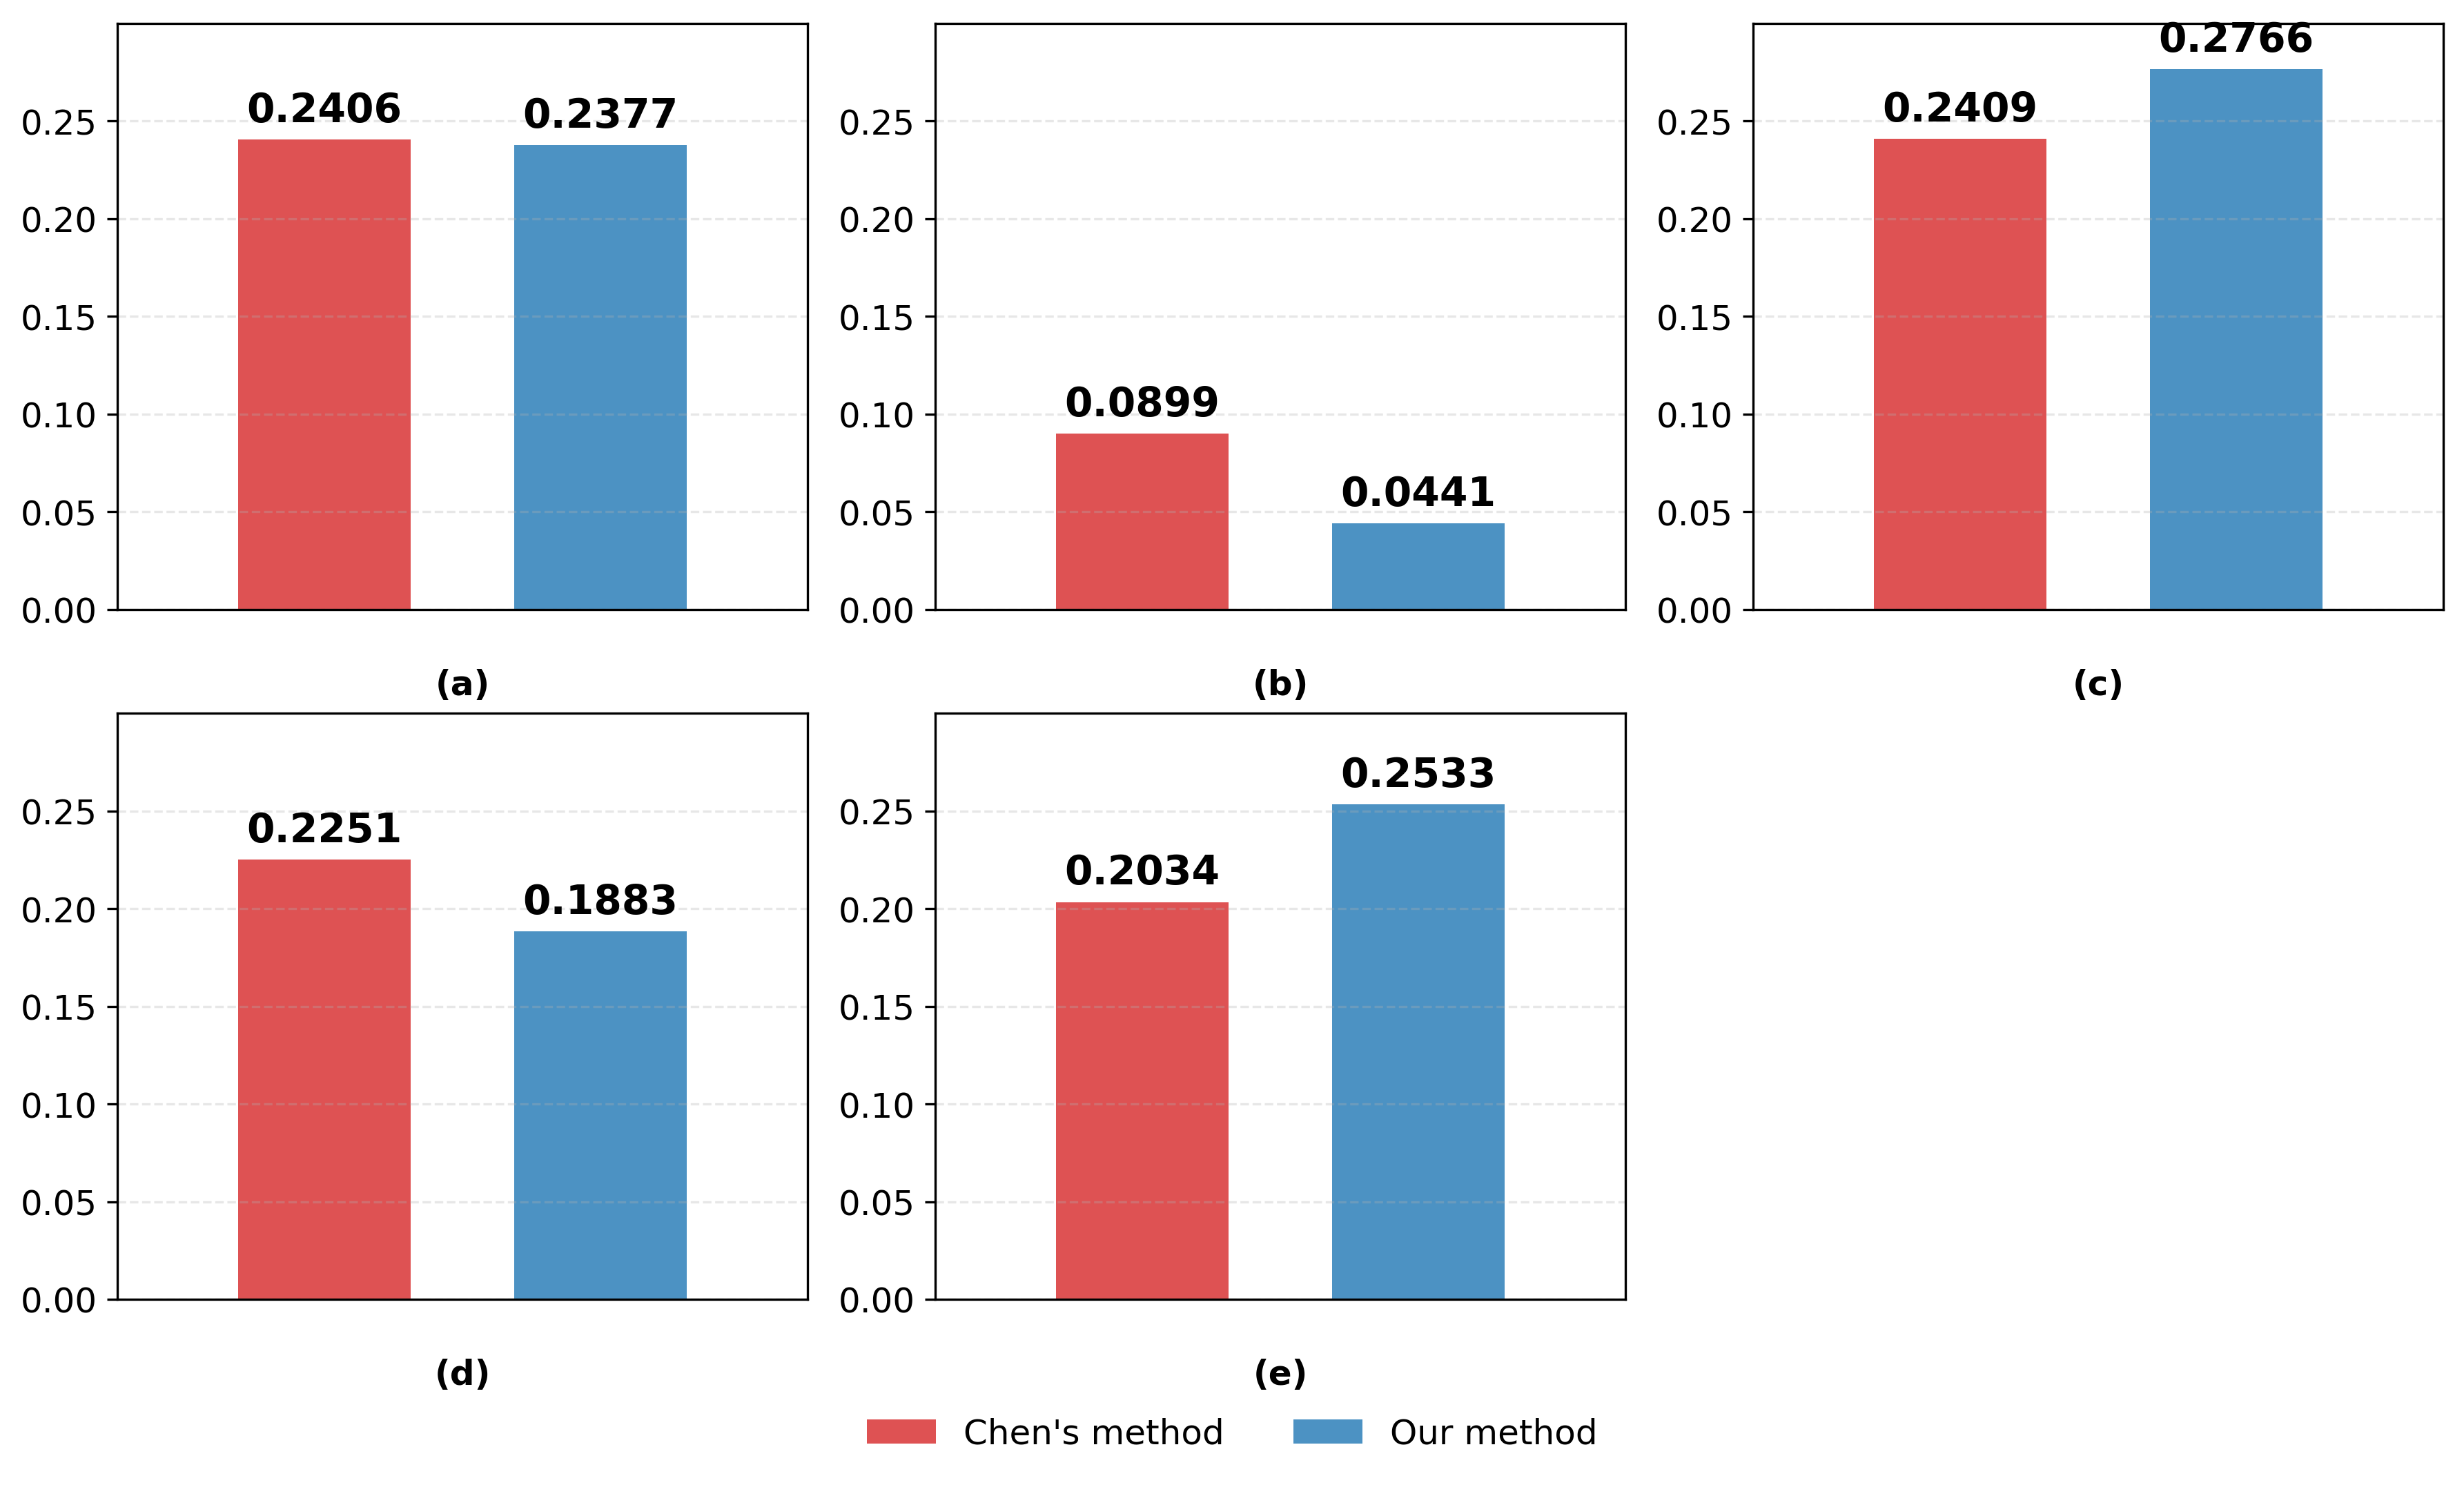

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体（如果需要显示中文）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 您的权重数据和论文数据
your_weights = [0.2377, 0.0441, 0.2766, 0.1883, 0.2533]
paper_weights = [0.2406, 0.0899, 0.2409, 0.2251, 0.2034]

# 标签和颜色设置
labels = ['(a)', '(b)', '(c)', '(d)', '(e)']
colors = ['#d62728', '#1f77b4']  # Paper=红色，Ours=蓝色

# 创建子图布局
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# 移除最后一个空子图
axes[-1].set_visible(False)

# 保存第一个子图的 bar 作为图例代理
legend_handles = None

# 绘制每个子图
for i, (ax, label) in enumerate(zip(axes[:-1], labels)):
    # 设置柱状图位置：两根柱子更近
    x_pos = [0.8, 1.2]
    values = [paper_weights[i], your_weights[i]]  # Paper在左，Ours在右

    # 绘制柱状图（柱宽调大）
    bars = ax.bar(x_pos, values, width=0.25, color=colors, alpha=0.8)

    # 保存第一幅图的 bar 用作图例
    if legend_handles is None:
        legend_handles = bars

    # 添加数值标签
    for x, val in zip(x_pos, values):
        ax.text(x, val + 0.005, f'{val:.4f}',
                ha='center', va='bottom', fontsize=14, fontweight='bold')

    # 设置子图属性
    ax.set_xlim(0.5, 1.5)  # 缩小x范围，让柱子更集中
    ax.set_ylim(0, 0.3)    # 统一Y轴范围为0-0.3
    ax.set_xticks([])      # 去除X轴标注
    ax.set_xticklabels([]) # 去除X轴标签
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # 添加y轴刻度
    ax.set_yticks([0, 0.05, 0.10, 0.15, 0.20, 0.25])
    ax.tick_params(axis='y', labelsize=12)

    # 把子图标签放在底部中央
    ax.text(0.5, -0.1, label, transform=ax.transAxes,
            ha='center', va='top', fontsize=12, fontweight='bold')

# 添加整体图例（下方居中）
fig.legend(legend_handles, ['Chen\'s method', 'Our method'],
           loc='lower center', bbox_to_anchor=(0.5, 0.07), ncol=2, fontsize=12,
           frameon=False)

# 调整布局
plt.tight_layout()
plt.subplots_adjust(bottom=0.18, top=0.95)

# 保存图片
plt.savefig("weight_comparison.pdf", bbox_inches='tight', transparent=True)
plt.show()


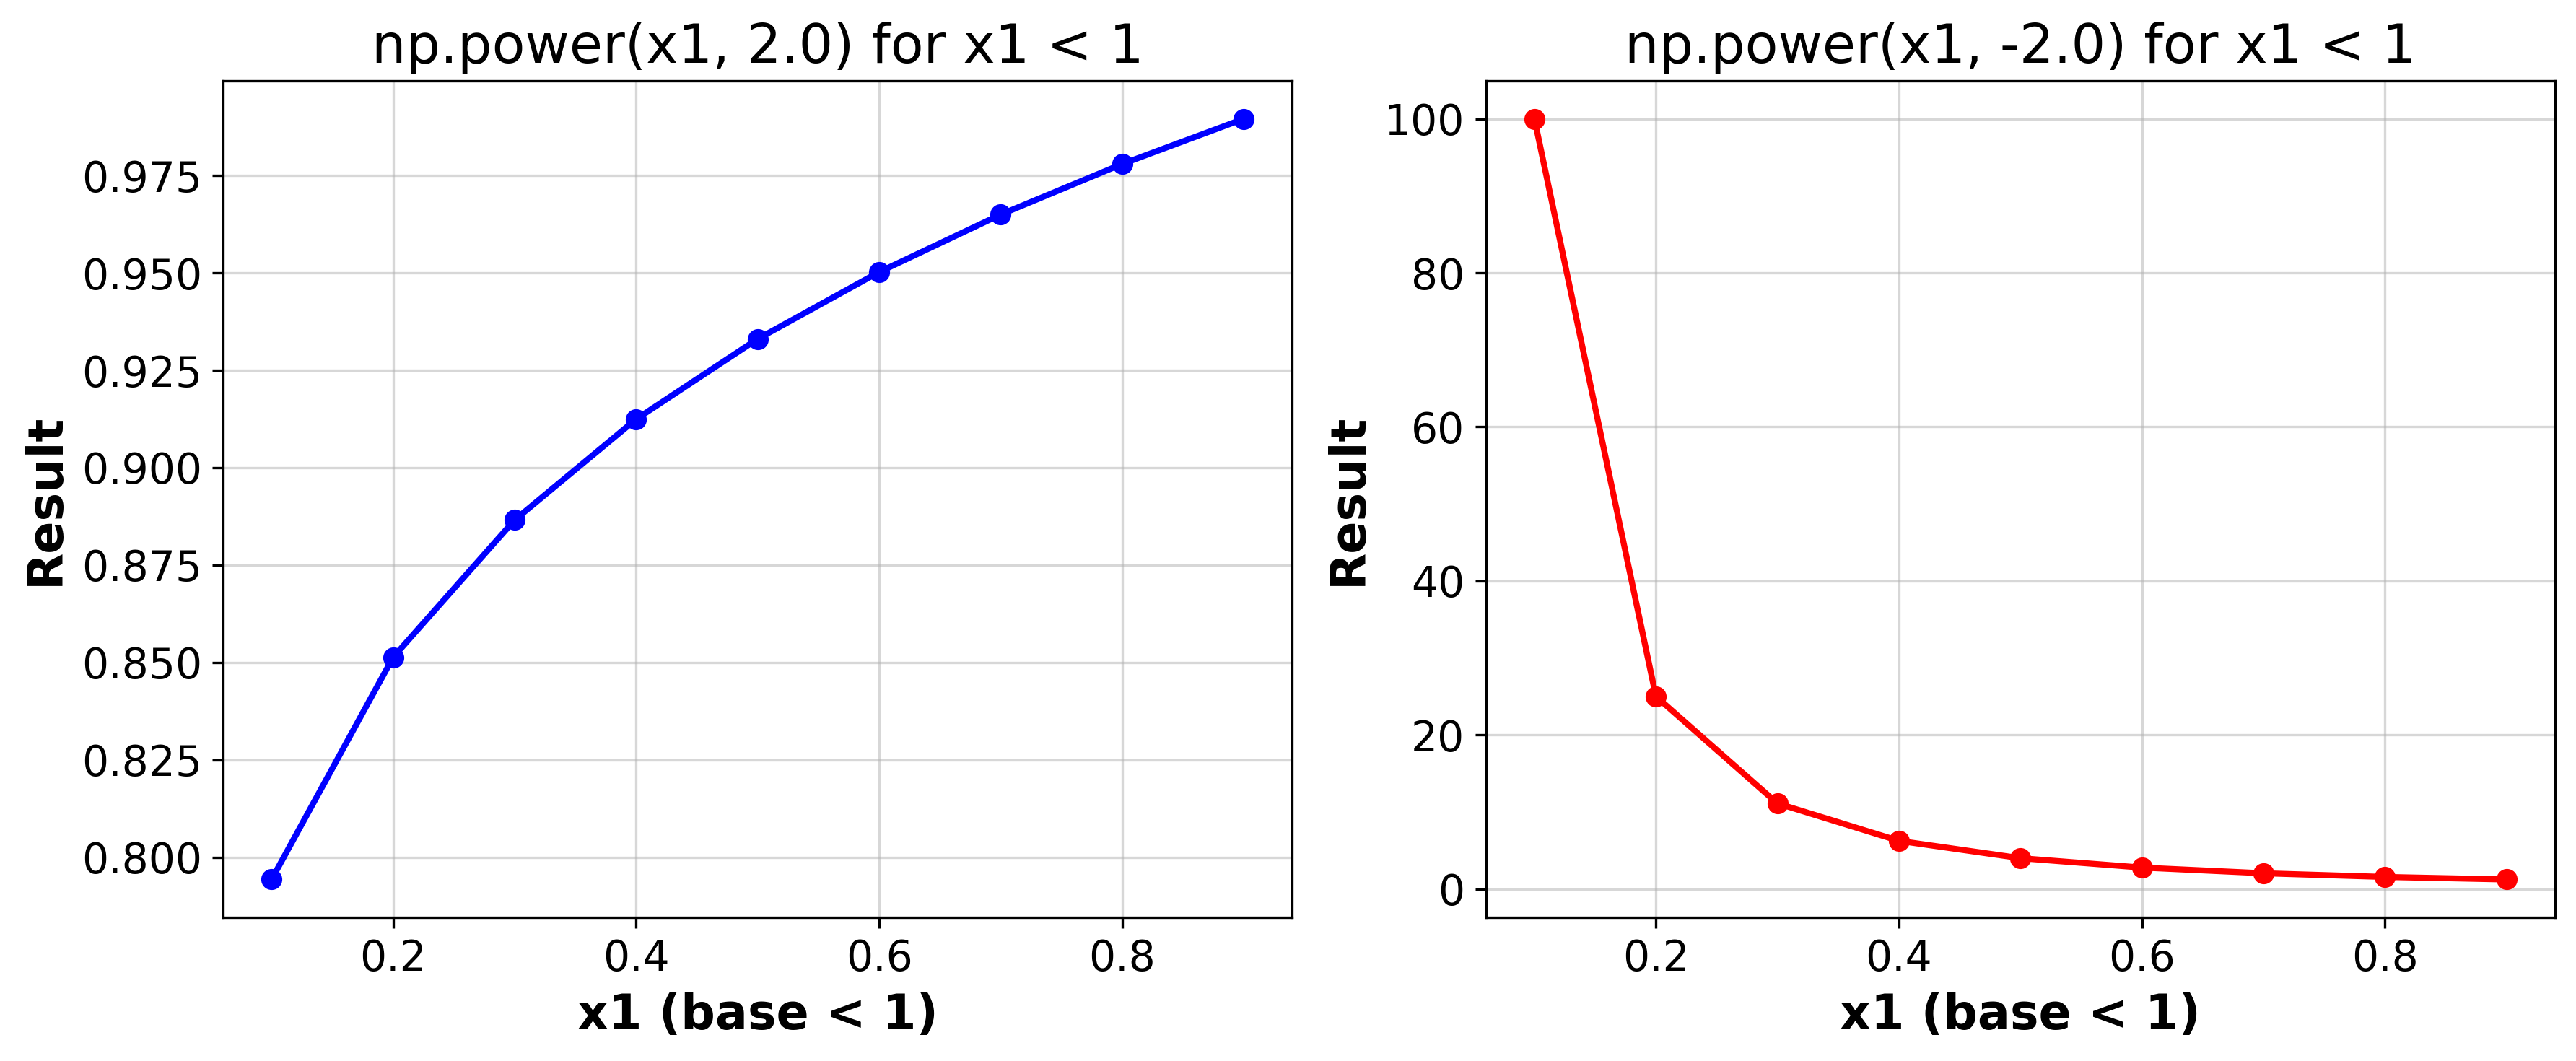

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# 创建示例数据
x1 = np.linspace(0.1, 0.9, 9)  # 底数从0.1到0.9
x2_pos = 0.1  # 正指数
x2_neg = -2.0 # 负指数

# 计算幂函数结果
y_pos = np.power(x1, x2_pos)   # x1^2
y_neg = np.power(x1, x2_neg)   # x1^(-2)

plt.figure(figsize=(12, 5))

# 正指数情况
plt.subplot(1, 2, 1)
plt.plot(x1, y_pos, 'b-o')
plt.title('np.power(x1, 2.0) for x1 < 1')
plt.xlabel('x1 (base < 1)')
plt.ylabel('Result')
plt.grid(True)

# 负指数情况
plt.subplot(1, 2, 2)
plt.plot(x1, y_neg, 'r-o')
plt.title('np.power(x1, -2.0) for x1 < 1')
plt.xlabel('x1 (base < 1)')
plt.ylabel('Result')
plt.grid(True)

plt.tight_layout()
plt.show()

In [33]:
import numpy as np

def geometric_mean_correction_with_stats(Crd, rps_weights_norm, eps=1e-12):
    """
    用几何均值 + Crd 的均值/方差构造逐元素修正因子（无条件判断版本）。
    返回归一化后的向量（和为1）。
    """
    Crd = np.asarray(Crd, dtype=float)
    rps = np.asarray(rps_weights_norm, dtype=float)

    # 全局统计量（自适应，无手动参数）
    mu = Crd.mean()
    sigma = Crd.std() + eps  # 防止除零

    # 标准化偏差 z（可正可负）
    # z = (Crd - mu) / sigma
    Delta_Cred_var = mu - Crd * (sigma / (mu + 1e-10))
    # 自适应系数 k：随分散度增加而增强调整力（无硬超参）
    k = 1 + (sigma / (mu + eps))

    M = k * Delta_Cred_var

    # 逐元素修正因子（z 越小 -> 因子越小）
    factor = np.exp(-Delta_Cred_var)
    # factor = np.power(rps,Delta_Cred_var)

    # 基础几何项（你之前用 abs 的版本效果不错）
    # 在乘法内加 eps 保证非负且避免 sqrt(0) 对数问题
    geometric_mean = np.sqrt(np.abs(Crd * factor)) * rps
    # print(geometric_mean)
    # 应用逐元素修正并归一化（确保输出是概率向量）
    # adjusted = geometric_mean * factor
    W = geometric_mean / (geometric_mean.sum() + eps)

    return W


Crd= [0.20525065 ,0.17839519, 0.20676316, 0.20474061, 0.20485039]
rps_weights_norm=[0.23705801, 0.04722939, 0.27488186, 0.18799658, 0.25283416]
W = geometric_mean_correction_with_stats(Crd, rps_weights_norm)
print(W)

[0.23769826 0.04411815 0.27664927 0.18826736 0.25326696]


In [34]:
def geometric_mean_correction(Crd, rps_weights_norm):
    """
    使用几何平均修正Crd
    """
    # 计算熵质量指标
    # entropy_quality = 1 - rps_weights_norm
    Crd = np.asarray(Crd, dtype=float)
    rps_weights_norm = np.asarray(rps_weights_norm, dtype=float)
    # 计算几何平均：sqrt(Crd * 熵质量)
        # 平移到正数域：始终减去 min(Crd)，再加上 eps
    geometric_mean = np.sqrt(np.abs(Crd * rps_weights_norm))
        # 计算 Crd 的均值和方差
    mean_crd = np.mean(Crd)
    var_crd = np.var(Crd)

    # 利用均值和方差作为全局修正系数
    # 均值增强稳定性，方差增强区分度
    correction_factor = np.sqrt(mean_crd / (var_crd + 1e-8))
    print("correction_factor",correction_factor)
    # 应用修正
    adjusted = geometric_mean * correction_factor
    # 归一化
    adjusted_Crd = adjusted / np.sum(adjusted)

    return adjusted_Crd

# 使用示例
Crd= [0.20525065 ,0.17839519, 0.20676316, 0.20474061, 0.20485039]
rps_weights_norm=[0.23705801, 0.04722939, 0.27488186, 0.18799658, 0.25283416]
# Crd= [ 0.33879269,-0.00837939,  0.3354188 ,  0.33416789]
# rps_weights_norm= [0.25077469 ,0.25593898, 0.24486733, 0.24841899]
adjusted_Crd = geometric_mean_correction(Crd, rps_weights_norm)
print("几何平均修正后的Crd:", adjusted_Crd)

correction_factor 41.305138647016975
几何平均修正后的Crd: [0.22634326 0.09418803 0.2446288  0.20131445 0.23352546]


In [35]:
def compute_weights_with_both_metrics_test(Crd, rps_weights_norm):
    Crd = np.asarray(Crd, dtype=float)
    rps_weights_norm = np.asarray(rps_weights_norm, dtype=float)
    mean_cred = Crd.mean()
    # print("mean_cred；", mean_cred)
    Delta_Cred = mean_cred - Crd
    std_cred = Crd.std()   # 缓存标准差
    # print("std_cred；", std_cred)
    Delta_Cred_var = mean_cred - Crd * (std_cred / (mean_cred + 1e-10))
    # print("std_cred / (mean_cred + 1e-10)" , std_cred / (mean_cred + 1e-10))
    # print("Delta_Cred；" , Delta_Cred)
    # print("Delta_Cred_var；" , Delta_Cred_var)
    base_correction = np.power(rps_weights_norm, Delta_Cred_var)
    # print("base_correction；", base_correction)
    # 第六步：计算修正后的可信度 (公式6-6扩展)
    Cred_H = Crd * base_correction
    # print("Cred_H",Cred_H)
    # 第七步：最终权重归一化 (公式6-8)
    W = Cred_H / (np.sum(Cred_H) + 1e-10)
    return W
Crd= [ 0.33879269,-0.00837939,  0.3354188 ,  0.33416789]
rps_weights_norm= [0.25077469 ,0.25593898, 0.24486733, 0.24841899]
adjusted_Crd = compute_weights_with_both_metrics_test(Crd, rps_weights_norm)
print("几何平均修正后的Crd:", adjusted_Crd)

几何平均修正后的Crd: [ 0.33903242 -0.00632886  0.33432523  0.33297122]


In [36]:
import numpy as np
import math
epsilon = 1e-12
def calculate_beta_from_RPS(RPS_list):
    """
    根据图片计算beta值：beta = 最大排列事件的基数
    图片中明确说明：β = max(|A_ij|)
    """
    all_events = set()
    for RPS in RPS_list:
        all_events.update(RPS.keys())

    if not all_events:
        return 1

    max_cardinality = max(len(event) for event in all_events)
    return max_cardinality

def RP_divergence(RPS1, RPS2, beta=None):
    """
    根据图片精确修正的RP散度计算 - 公式(14)

    图片中的公式：D_RP(RPS1||RPS2) = 1/(β-1) * log( Σ (M1^β / M2^(β-1)) )
    但图片示例中显示为 M2^(-2)，这是因为当β=3时，(β-1)=2，但写成了负号（可能是排版错误）
    """
    all_events = set(RPS1.keys()) | set(RPS2.keys())

    # 如果未指定beta，使用最大事件基数
    if beta is None:
        beta = calculate_beta_from_RPS([RPS1, RPS2])

    # 特殊情况：当beta=1时，RP散度退化为KL散度
    if beta == 0:
        kl_divergence = 0
        for event in all_events:
            M1 = RPS1.get(event, 0.0)
            M2 = RPS2.get(event, 0.0)

            if M1 > 0 and M2 > 0:
                kl_divergence += M1 * math.log(M1 / M2)
            # elif M1 > 0 and M2 == 0:
            #     return float('inf')

        return kl_divergence

    else:
        summation = 0
        valid_events = 0

        for event in all_events:
            M1 = RPS1.get(event, epsilon)
            M2 = RPS2.get(event, epsilon)
            if M1 == 0:
                M1 = epsilon
            if M2 == 0:
                M2 = epsilon
            # 关键修正：按照图片中的数学定义，应该是 M2^(β-1)
            # 但图片示例中显示为负指数，这不符合数学定义，我们采用正确的数学定义
            # if M2 > 0 and M1 > 0:
            # 正确的数学公式：M1^β / M2^(β-1)
            term = (M1 ** beta) / (M2 ** (beta - 1))
            summation += term
            valid_events += 1
            # elif M1 > 0 and M2 == 0:
            #     return float('inf')

        # if valid_events == 0:
        #     return float('inf')
        #
        # if summation <= 0:
        #     return float('inf')

        return (1 / (beta - 1)) * math.log2(summation)


def SRP_divergence(RPS1, RPS2, beta=None):
    """
    对称RP散度计算 - 公式(15)
    D_SRP(RPS1||RPS2) = [D_RP(RPS1||RPS2) + D_RP(RPS2||RPS1)] / 2
    """
    # beta = calculate_beta_from_RPS([RPS1, RPS2])
    drp_12 = RP_divergence(RPS1, RPS2, beta)
    drp_21 = RP_divergence(RPS2, RPS1, beta)

    # if math.isinf(drp_12) or math.isinf(drp_21):
    #     return float('inf')

    return (drp_12 + drp_21) / 2


def build_SRP_matrix(RPS_list, gamma):
    """
    SRP矩阵构建 - 公式(16)
    构建n×n的对称散度矩阵
    """
    n = len(RPS_list)
    SRPM = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                SRPM[i, j] = 0.0  # 自散度为0
            else:
                divergence = SRP_divergence(RPS_list[i], RPS_list[j])
                SRPM[i, j] = max(0.0, divergence)

    return SRPM

example_data2 = [
     {  # RPS₁
         ('A',): 0.3,  # <(γ1), 0.75>
         ('B','C'): 0.3,  # <(γ2), 0.12>
         ('A', 'B','C'): 0.4  # <(γ3,γ4), 0.13>
     },
     {  # RPS₂
         ('A',): 0.4,  # <(γ1), 0.00>
         ('B','C'): 0.2,  # <(γ2), 0.12>
         ('A', 'B','C'): 0.4
     }
]
beta = calculate_beta_from_RPS(example_data2)
RPS1_RPS2 = RP_divergence(example_data2[0], example_data2[1],beta)
print("RPS1_RPS2", RPS1_RPS2)

RPS1_RPS2 0.1573482628281432


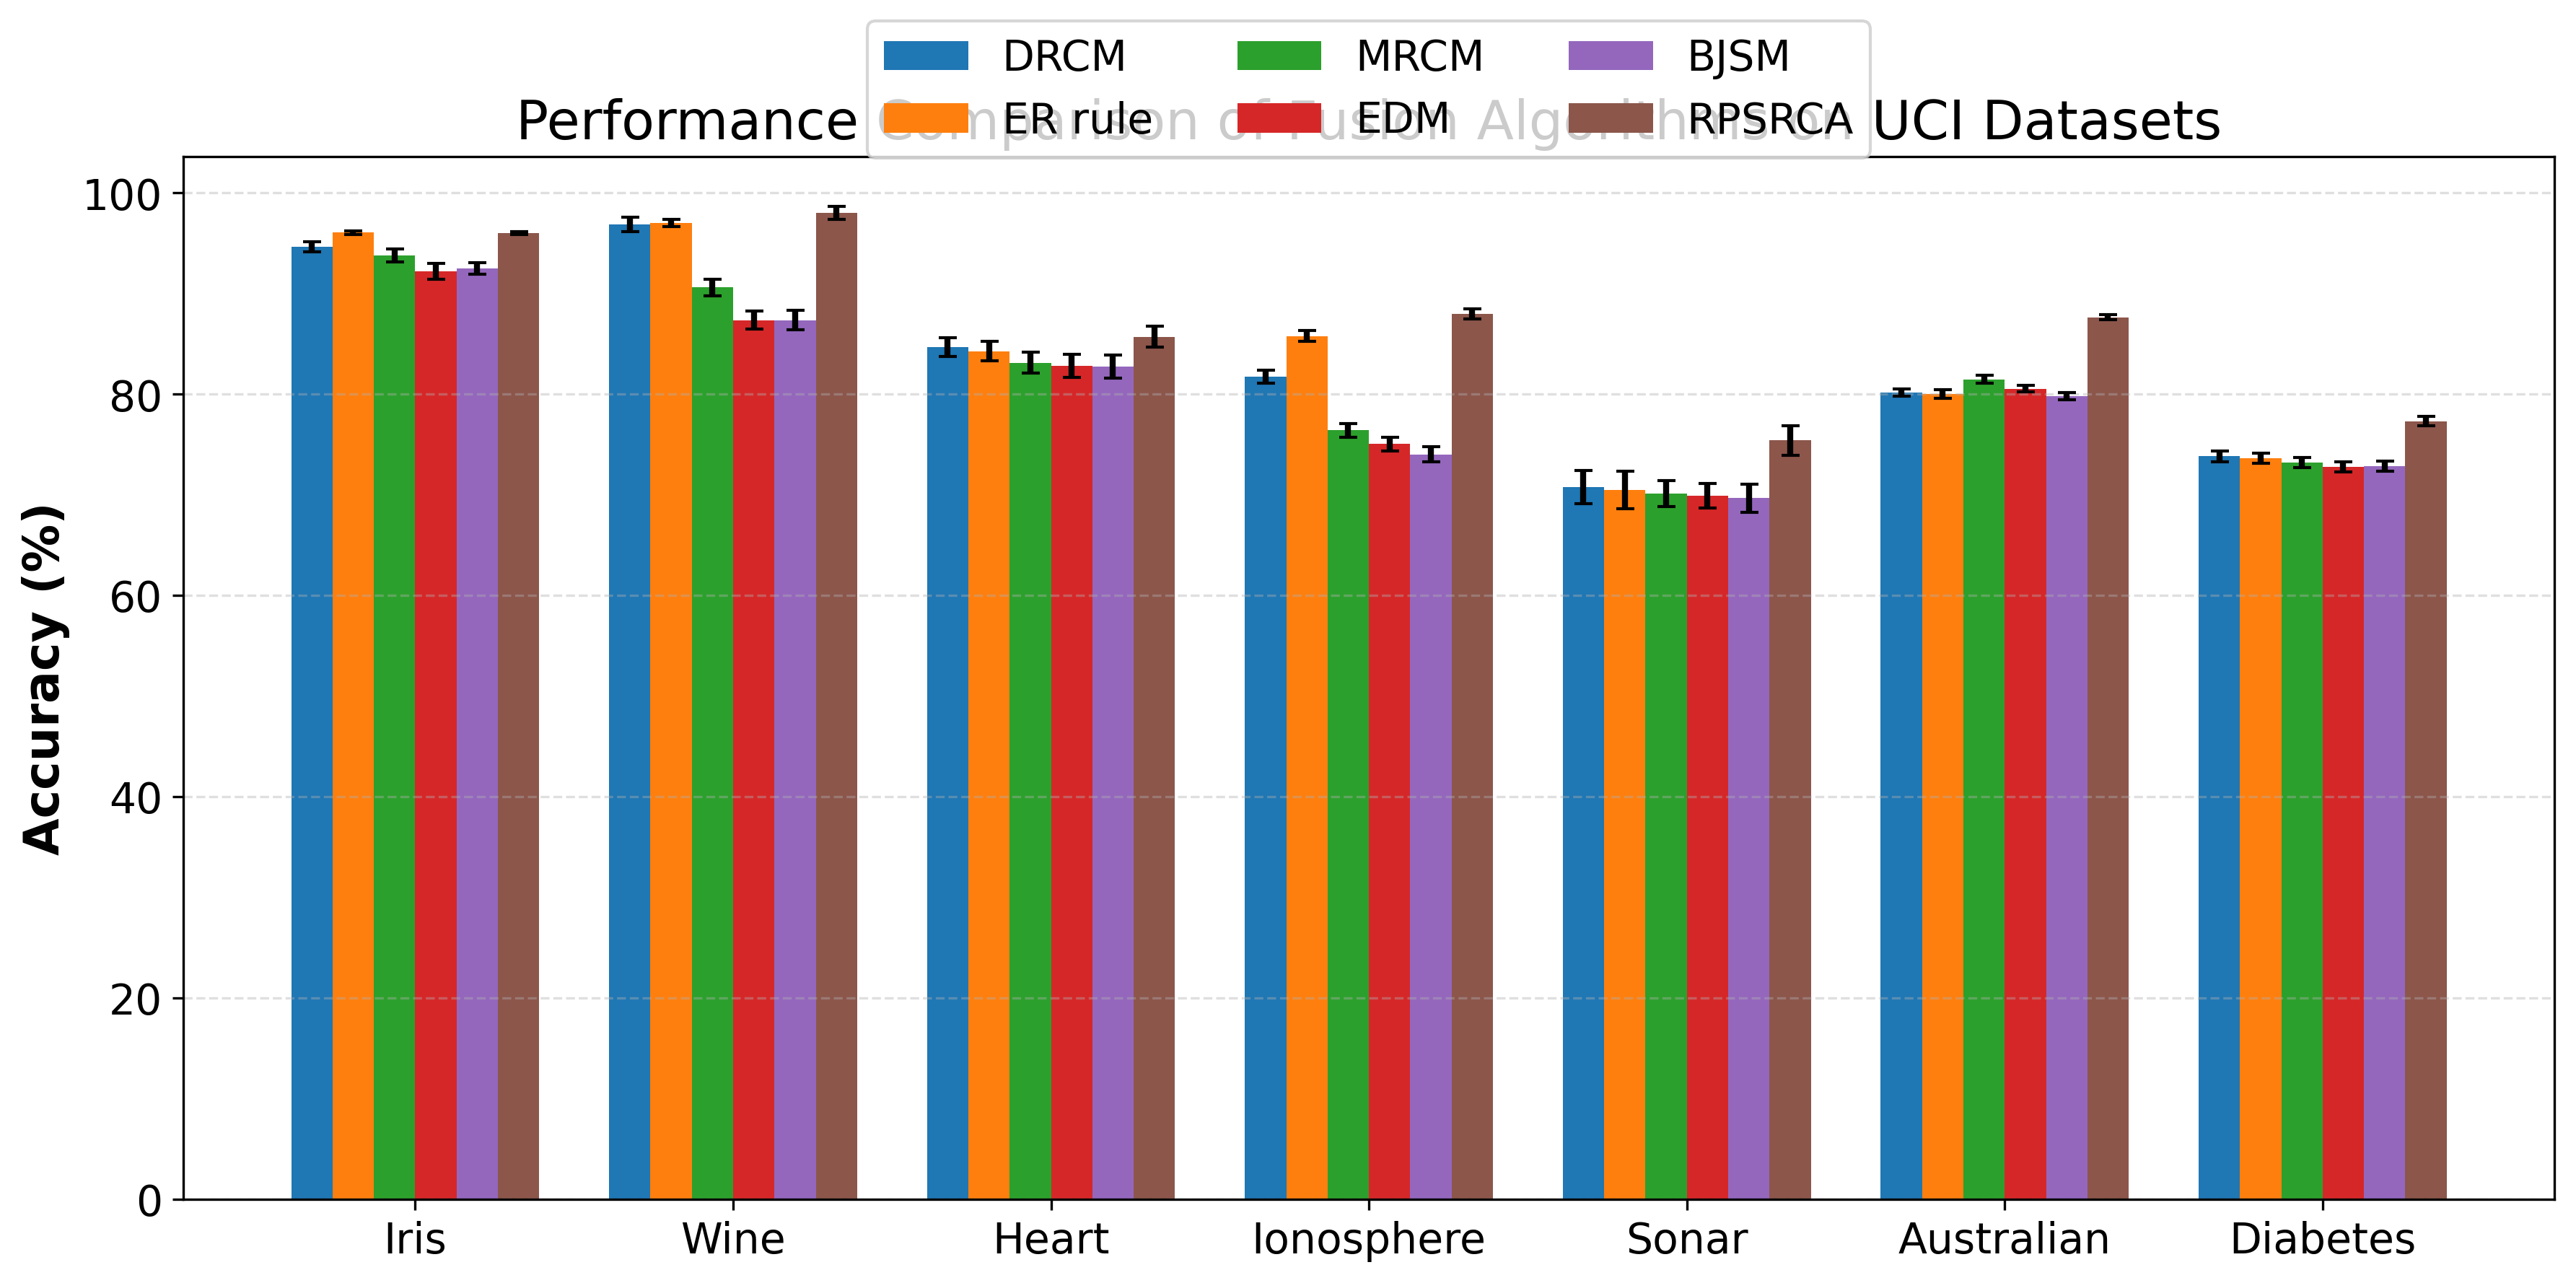

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
datasets = ["Iris", "Wine", "Heart", "Ionosphere", "Sonar", "Australian", "Diabetes"]
algorithms = ["DRCM", "ER rule", "MRCM", "EDM", "BJSM", "RPSRCA"]

means = np.array([
    [94.65, 96.06, 93.79, 92.19, 92.49, 95.99],
    [96.86, 97.00, 90.60, 87.36, 87.34, 98.04],
    [84.66, 84.27, 83.13, 82.81, 82.71, 85.70],
    [81.73, 85.78, 76.41, 75.03, 74.02, 87.97],
    [70.76, 70.46, 70.12, 69.90, 69.66, 75.39],
    [80.14, 79.98, 81.48, 80.55, 79.80, 87.65],
    [73.84, 73.63, 73.21, 72.77, 72.86, 77.31]
])

stds = np.array([
    [0.51, 0.19, 0.64, 0.81, 0.60, 0.13],
    [0.71, 0.36, 0.85, 0.90, 0.96, 0.65],
    [0.95, 0.96, 1.05, 1.14, 1.15, 1.02],
    [0.63, 0.53, 0.68, 0.68, 0.75, 0.51],
    [1.66, 1.86, 1.29, 1.25, 1.41, 1.46],
    [0.34, 0.43, 0.37, 0.35, 0.38, 0.26],
    [0.54, 0.53, 0.52, 0.48, 0.52, 0.47]
])

# 绘制
x = np.arange(len(datasets))
bar_width = 0.13

plt.figure(figsize=(12,6))
for i, algo in enumerate(algorithms):
    plt.bar(x + i*bar_width, means[:, i], yerr=stds[:, i], capsize=3, width=bar_width, label=algo)

plt.xticks(x + bar_width*2.5, datasets)
plt.ylabel("Accuracy (%)")
plt.title("Performance Comparison of Fusion Algorithms on UCI Datasets")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


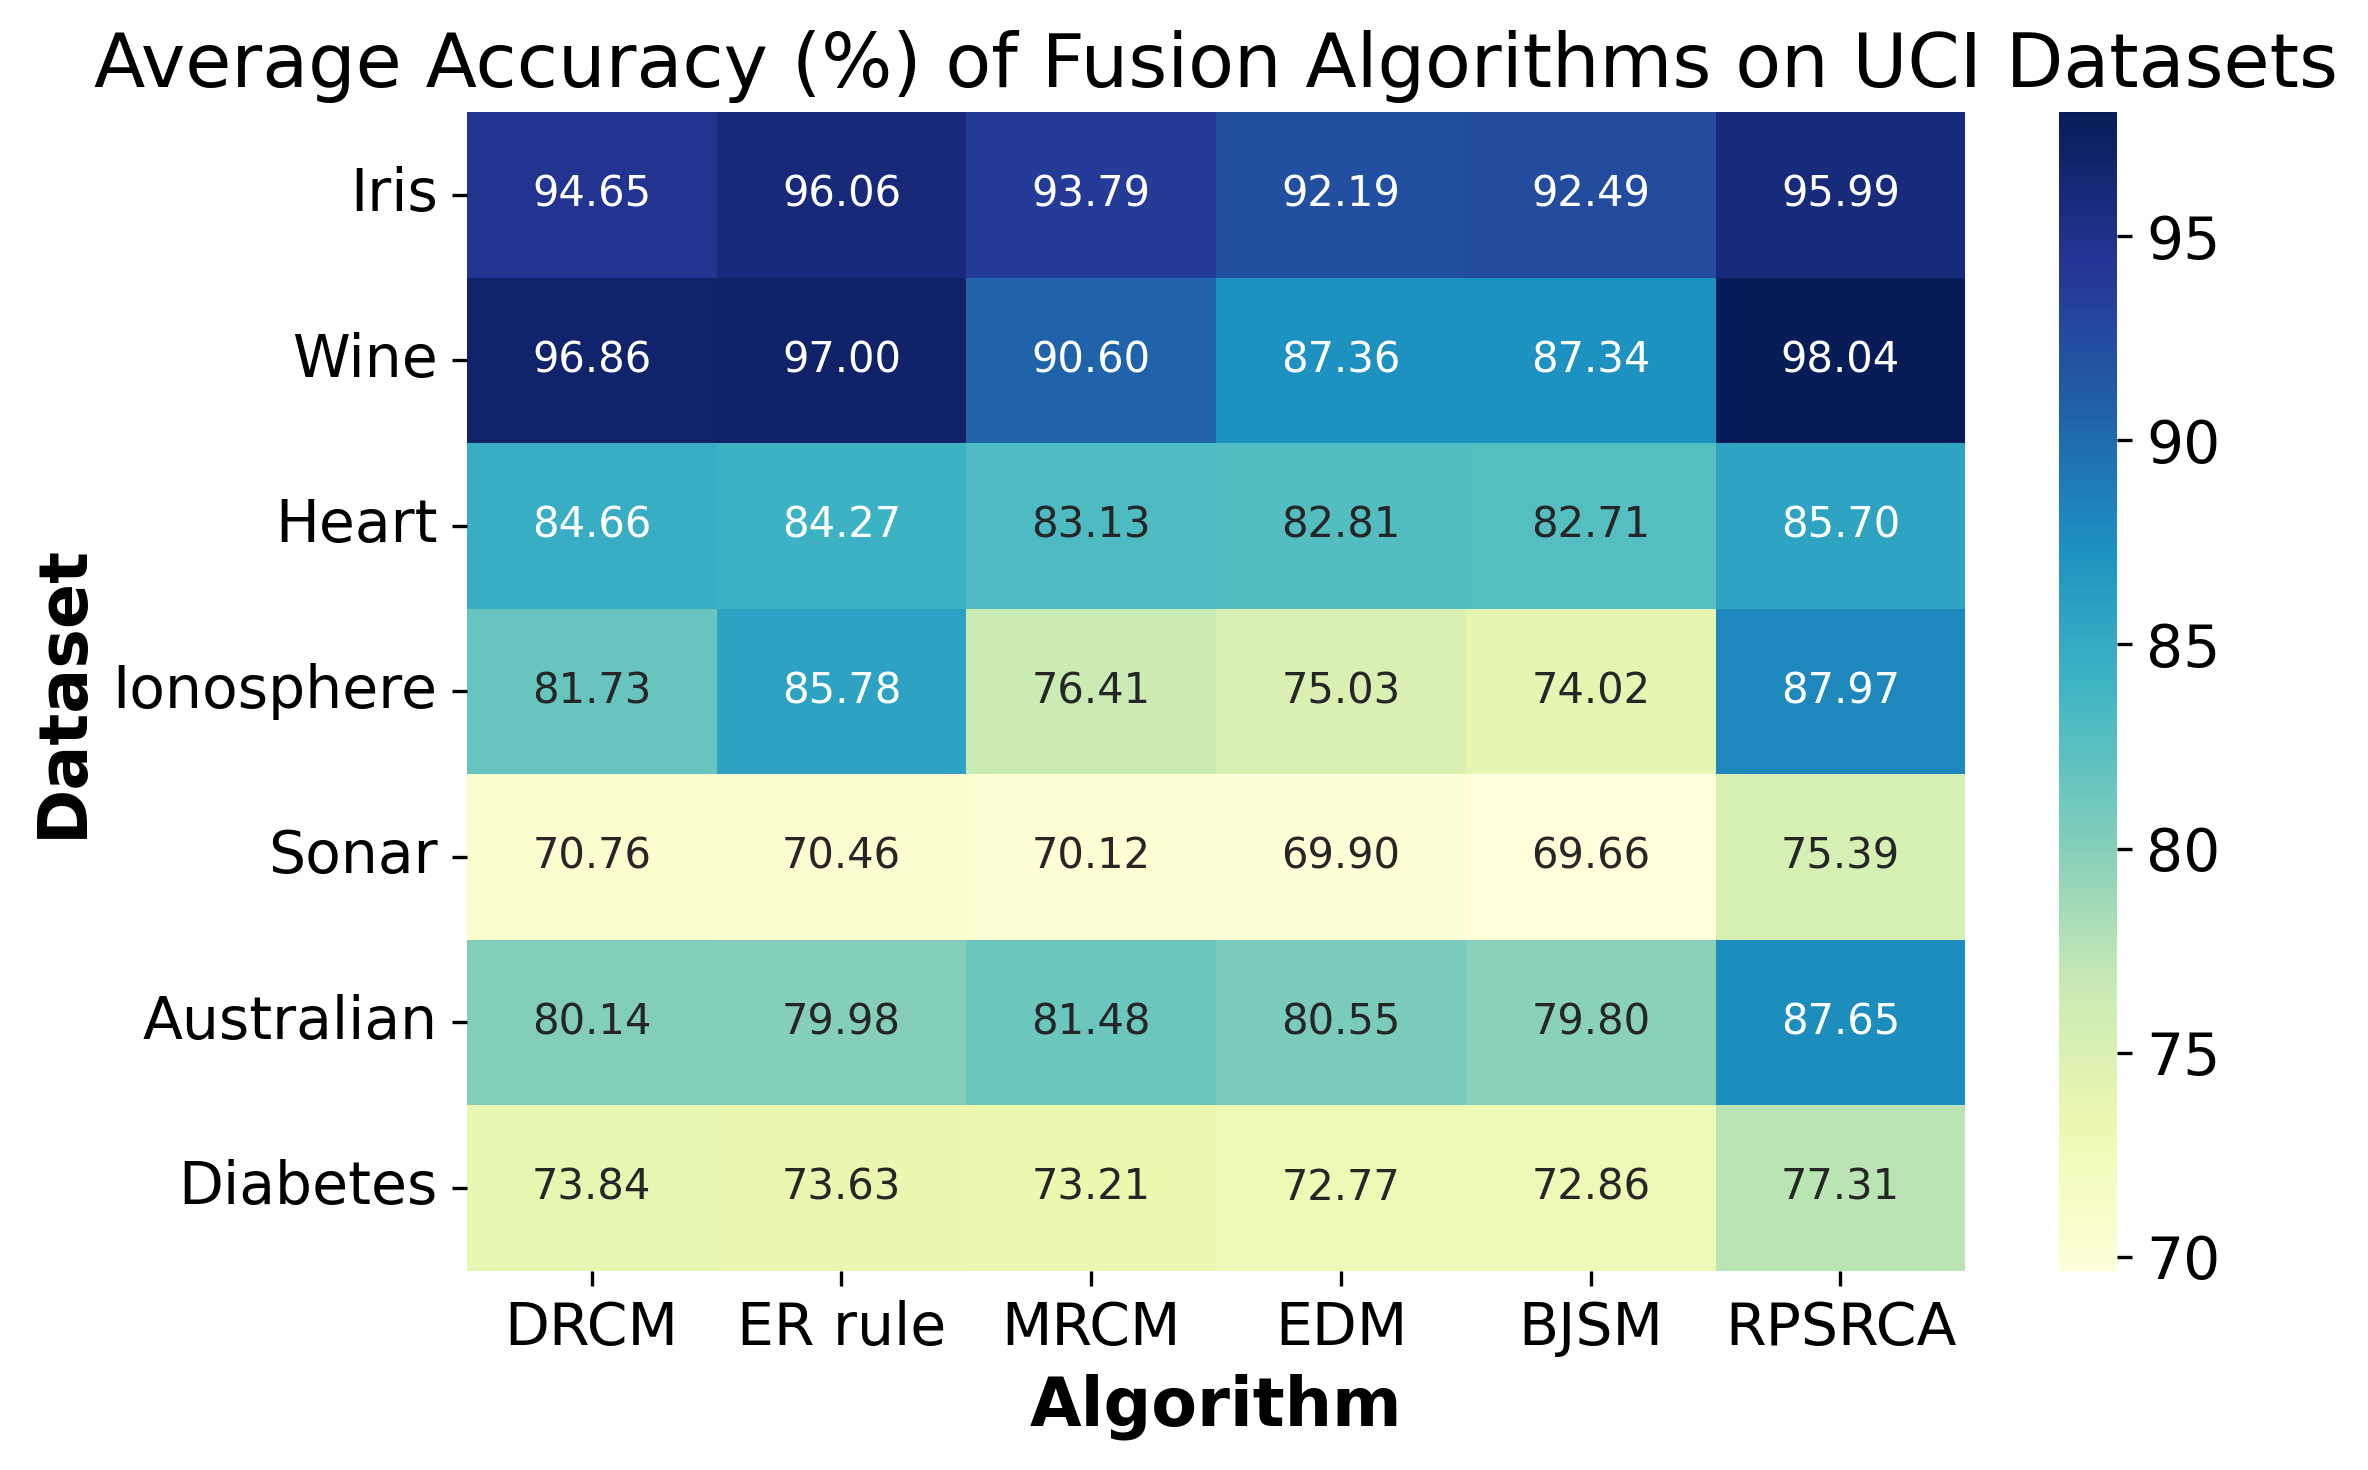

In [39]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(means, index=datasets, columns=algorithms)

plt.figure(figsize=(8,5))
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Accuracy (%) of Fusion Algorithms on UCI Datasets")
plt.xlabel("Algorithm")
plt.ylabel("Dataset")
plt.tight_layout()
plt.show()

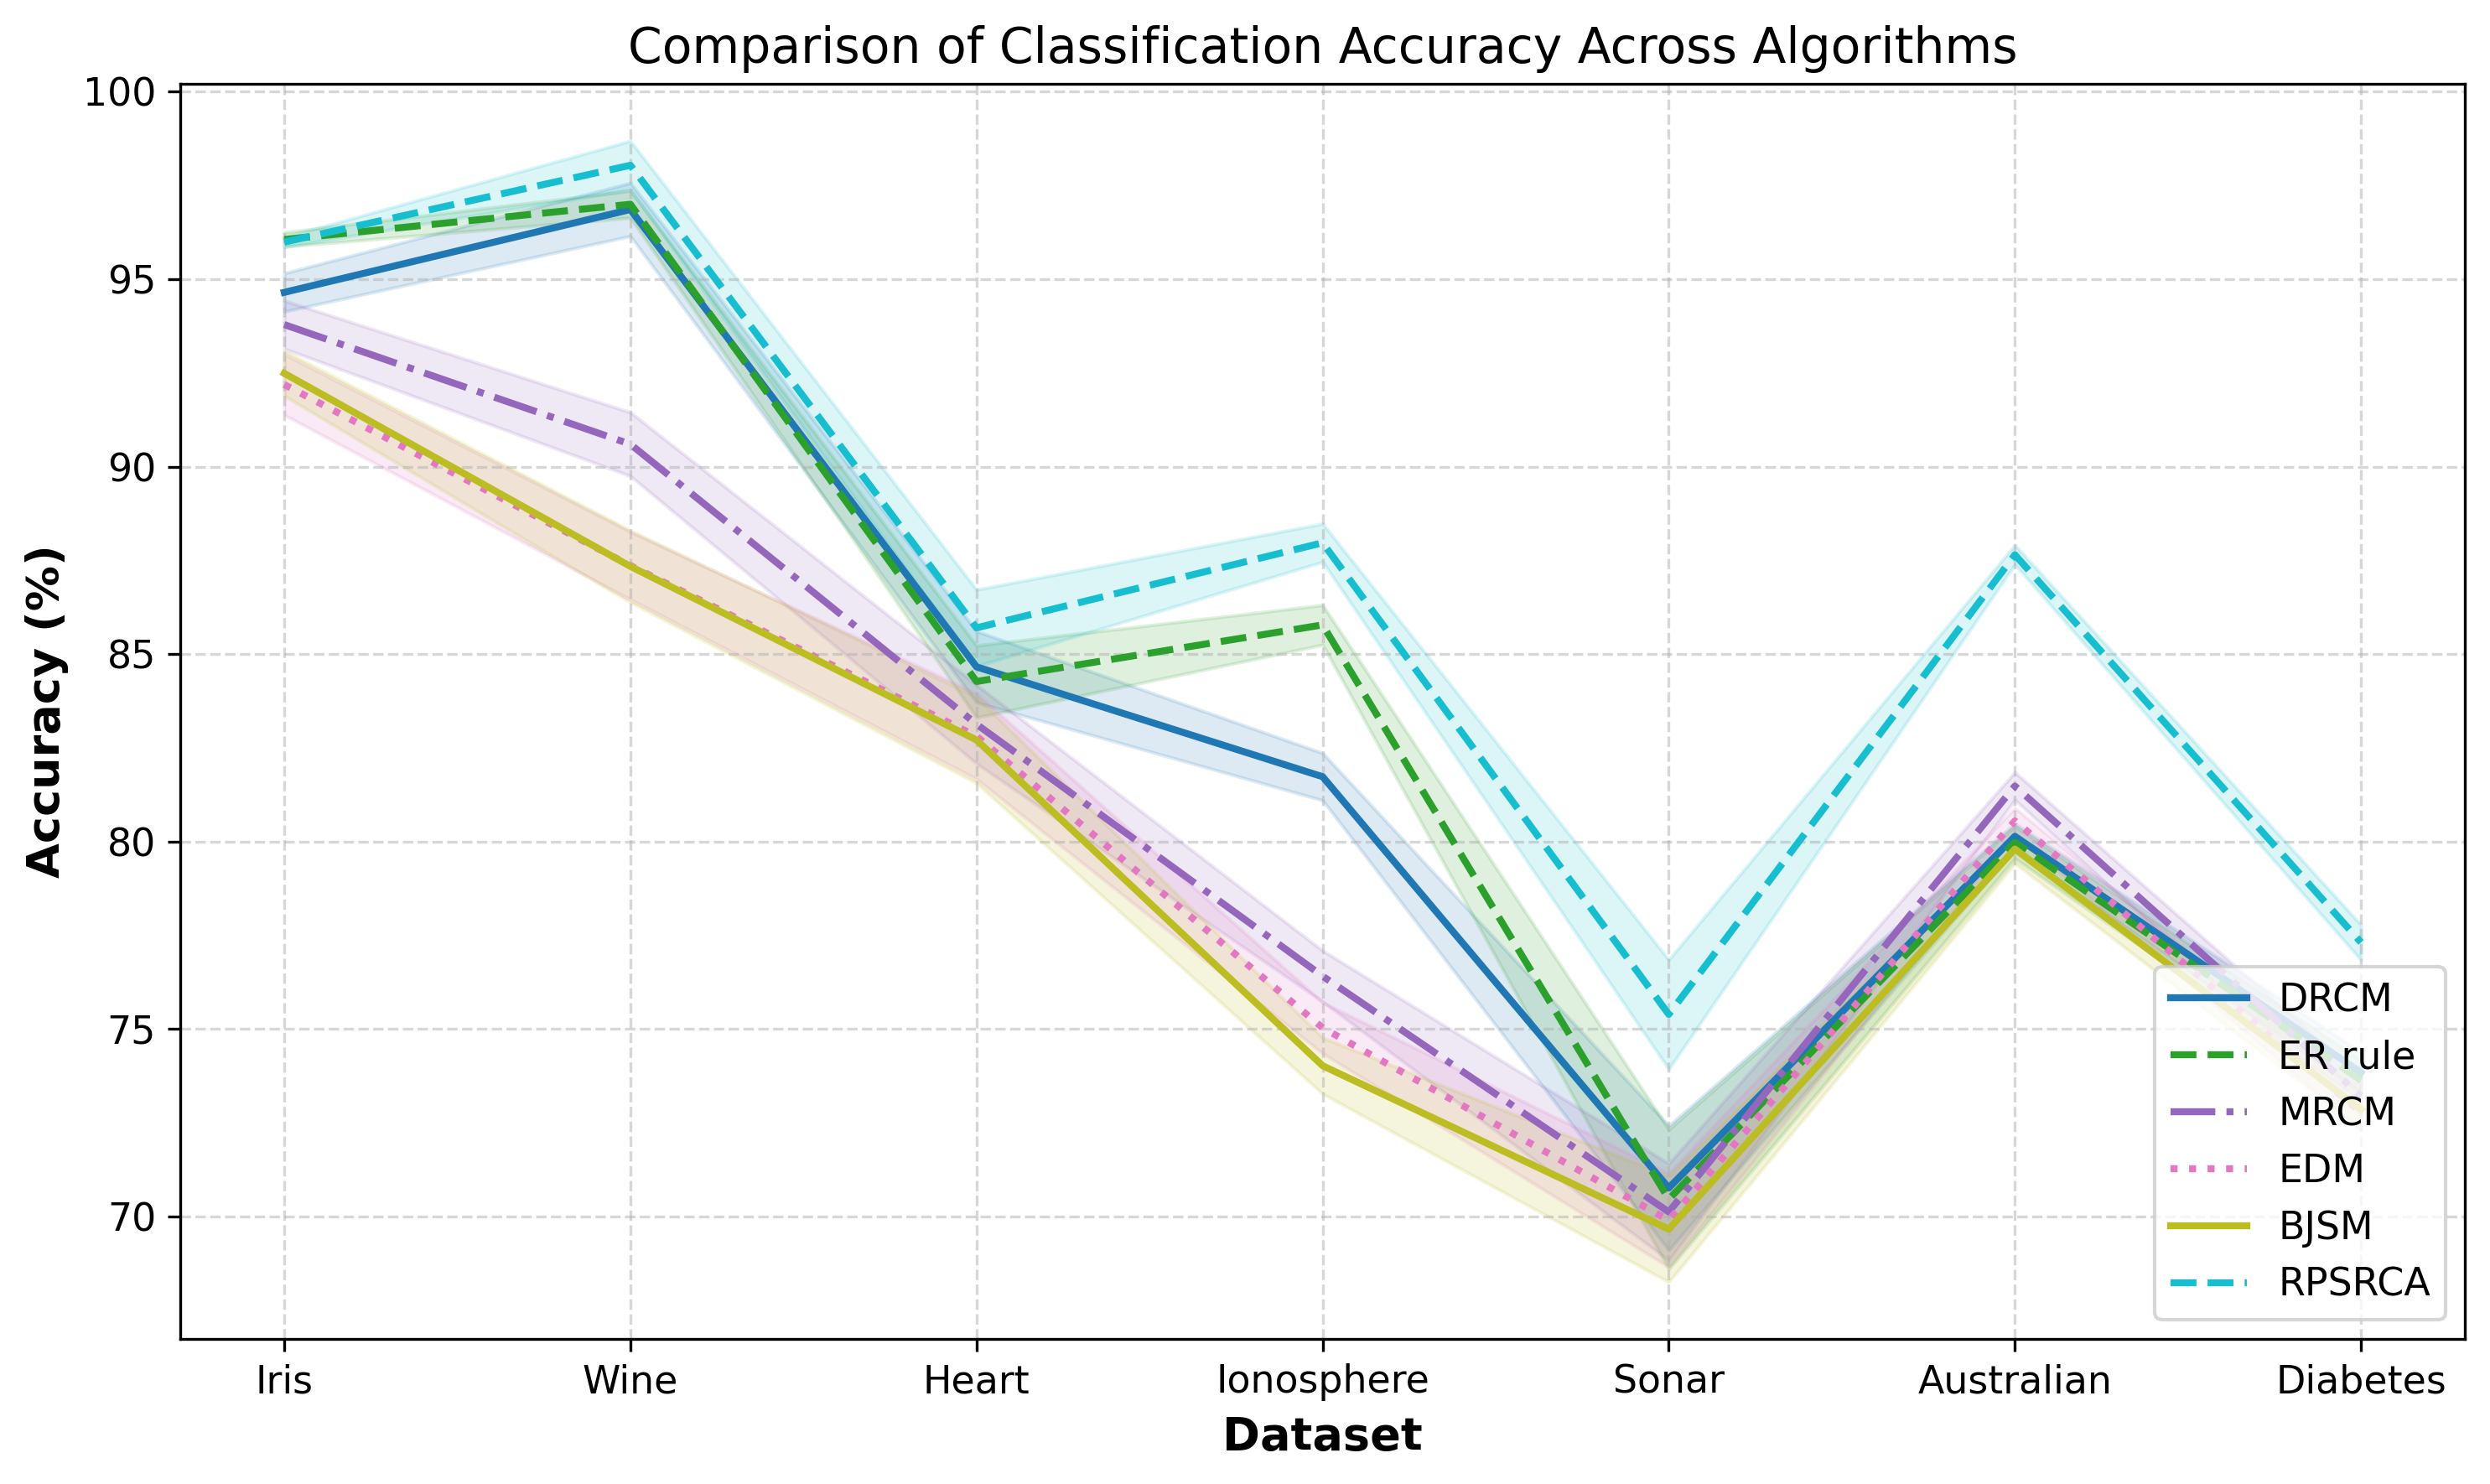

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# 数据输入部分（均值 ± 标准差）
# ==============================
datasets = ["Iris", "Wine", "Heart", "Ionosphere", "Sonar", "Australian", "Diabetes"]

# 各算法的均值（accuracy）与标准差
algorithms = {
    "DRCM": {
        "mean": [94.65, 96.86, 84.66, 81.73, 70.76, 80.14, 73.84],
        "std":  [0.51, 0.71, 0.95, 0.63, 1.66, 0.34, 0.54]
    },
    "ER rule": {
        "mean": [96.06, 97.00, 84.27, 85.78, 70.46, 79.98, 73.63],
        "std":  [0.19, 0.36, 0.96, 0.53, 1.86, 0.43, 0.53]
    },
    "MRCM": {
        "mean": [93.79, 90.60, 83.13, 76.41, 70.12, 81.48, 73.21],
        "std":  [0.64, 0.85, 1.05, 0.68, 1.29, 0.37, 0.52]
    },
    "EDM": {
        "mean": [92.19, 87.36, 82.81, 75.03, 69.90, 80.55, 72.77],
        "std":  [0.81, 0.90, 1.14, 0.68, 1.25, 0.35, 0.48]
    },
    "BJSM": {
        "mean": [92.49, 87.34, 82.71, 74.02, 69.66, 79.80, 72.86],
        "std":  [0.60, 0.96, 1.15, 0.75, 1.41, 0.38, 0.52]
    },
    "RPSRCA": {
        "mean": [95.99, 98.04, 85.70, 87.97, 75.39, 87.65, 77.31],
        "std":  [0.13, 0.65, 1.02, 0.51, 1.46, 0.26, 0.47]
    }
}

# ==============================
# 绘图部分
# ==============================
plt.figure(figsize=(10, 6))
x = np.arange(len(datasets))

# 为不同算法选择可区分的颜色和线型
colors = plt.cm.tab10(np.linspace(0, 1, len(algorithms)))
linestyles = ['-', '--', '-.', ':', '-', '--']

for (i, (name, data)) in enumerate(algorithms.items()):
    mean = np.array(data["mean"])
    std = np.array(data["std"])
    plt.plot(x, mean, label=name, color=colors[i], linestyle=linestyles[i], linewidth=2)
    plt.fill_between(x, mean - std, mean + std, color=colors[i], alpha=0.15)

# ==============================
# 图形美化
# ==============================
plt.xticks(x, datasets, fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Dataset", fontsize=13)
plt.ylabel("Accuracy (%)", fontsize=13)
plt.title("Comparison of Classification Accuracy Across Algorithms", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=11, loc="lower right", frameon=True)

plt.tight_layout()
plt.show()